In [1]:
# Pipeline Completo de Clasificación de Éxito Comercial con Embeddings y Corrección por Inflación
#
# Este notebook implementa un pipeline completo para predecir el éxito comercial de películas
# usando el dataset limpiado con embeddings de texto. Convierte el problema de regresión
# (predecir revenue) en clasificación (exitoso/no exitoso) para mayor interpretabilidad.
# **NUEVO**: Incluye corrección por inflación para budget y revenue.


In [2]:
import warnings
import os
import json
import math
import time
from pathlib import Path

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score,
    classification_report, confusion_matrix, make_scorer, brier_score_loss, 
    log_loss, roc_curve
)

# Importar display classes si están disponibles
try:
    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
    HAS_DISPLAY_CLASSES = True
except ImportError:
    HAS_DISPLAY_CLASSES = False

try:
    from sklearn.calibration import CalibrationDisplay
    HAS_CALIBRATION_DISPLAY = True
except ImportError:
    HAS_CALIBRATION_DISPLAY = False

# Modelos
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Configuración
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Constantes del pipeline - OPTIMIZADAS según análisis descriptivo
RANDOM_STATE = 42

# Split temporal: mantener 2014 según tu configuración
YEAR_SPLIT = 2014
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.15

# SVD: usar embeddings completos según hallazgos (R² = 0.748 con embeddings completos)
N_SVD = 200  # Mantener tu valor pero sabiendo que podrías usar las 3072 completas

# Umbral de éxito: ajustar según distribución heavy-tail observada
Q_SUCCESS = 0.65  # Reducido de 0.70 por la distribución sesgada

# Año base para inflación (2023 como referencia)
BASE_YEAR = 2023

# OBLIGATORIO: usar valores reales según análisis (mejora R² +0.62% en log)
LOG_REAL_REVENUE = True  # Transformación log a revenue_real_2023
LOG_REAL_BUDGET = True   # Transformación log a budget_real_2023

In [3]:
# ## 1. Funciones Auxiliares (Incluyendo Corrección por Inflación)

def unwrap_embedding(X_col):
    """Convierte columna de embeddings a matriz numpy"""
    if isinstance(X_col, (pd.Series, pd.DataFrame)):
        vals = X_col.squeeze().to_numpy()
    else:
        vals = np.array(X_col).squeeze()

    embeddings = []
    for v in vals:
        if isinstance(v, (list, tuple)):
            embeddings.append(np.array(v, dtype=np.float32))
        elif isinstance(v, np.ndarray):
            embeddings.append(v.astype(np.float32))
        else:
            embeddings.append(np.zeros(384, dtype=np.float32))

    return np.vstack(embeddings)


def l2_normalize_rows(X, eps=1e-12):
    """Normaliza cada fila usando norma L2"""
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.maximum(norms, eps)


def winsorize_series(series, low_q=0.01, high_q=0.99):
    """Aplica winsorización para controlar valores extremos"""
    low_val, high_val = series.quantile([low_q, high_q])
    winsorized = series.clip(lower=low_val, upper=high_val)
    return winsorized, float(low_val), float(high_val)


def to_float_array(X):
    """Helper para conversión a float32"""
    return np.asarray(X, dtype=np.float32)




In [4]:
# ## 3. Preparación de Datos y Split Temporal (CORREGIDO)

def prepare_data_and_split(year_threshold=YEAR_SPLIT, min_positive_test=50, target_success_rate=0.3,
                           use_inflation_adjusted=True):
    """Prepara los datos y aplica split temporal con balanceo automático.
       NUEVO: permite log opcional sobre valores REALES de revenue/budget por separado cuando no se usa inflación."""
    print("\n" + "=" * 60)
    print("PREPARACIÓN DE DATOS Y SPLIT TEMPORAL")
    print("=" * 60)

    # APLICAR CORRECCIÓN POR INFLACIÓN (siempre se calcula para análisis/plots; luego decidimos qué usar para el modelo)
    print(f"\nAplicando corrección por inflación (año base: {BASE_YEAR})...")
    df_clean = pd.read_pickle('../../data/processed_data/dataset_inflation_adjusted.pkl')

    # Decidir qué valores usar para el target (revenue_for_model) y para features (budget_for_model)
    # NUEVO: si NO usamos inflación, podemos aplicar log1p a los valores REALES de forma independiente.
    if use_inflation_adjusted:
        print(f"Usando valores AJUSTADOS por inflación para crear variable objetivo y budget de modelo")
        revenue_for_target = df_clean['revenue_real_2023']
        budget_for_features = df_clean['budget_real_2023']
        revenue_suffix = "_adjusted"
    else:
        print(f"Usando valores REALES (originales) para crear variable objetivo y budget de modelo")
        if LOG_REAL_REVENUE:
            print("   • LOG_REAL_REVENUE=True → revenue_for_model = log1p(revenue)")
            revenue_for_target = np.log1p(df_clean['revenue'].astype(np.float64))
            revenue_suffix = "_log"
        else:
            revenue_for_target = df_clean['revenue']
            revenue_suffix = ""

        if LOG_REAL_BUDGET:
            print("   • LOG_REAL_BUDGET=True → budget_for_model = log1p(budget)")
            budget_for_features = np.log1p(df_clean['budget'].astype(np.float64))
        else:
            budget_for_features = df_clean['budget']

    # Guardar columnas que usará el modelo (independientes del resto de columnas originales/ajustadas)
    df_clean['revenue_for_model'] = revenue_for_target
    df_clean['budget_for_model'] = budget_for_features

    # Crear variables derivadas
    if 'release_date' in df_clean.columns:
        df_clean['release_month'] = pd.to_datetime(df_clean['release_date'], errors='coerce').dt.month
        df_clean['release_month'] = df_clean['release_month'].fillna(6).astype(int)
    else:
        print("Columna 'release_date' no encontrada, usando mes por defecto (6)")
        df_clean['release_month'] = 6

    # Split temporal
    print(f"\nAplicando split temporal (umbral: {year_threshold})...")
    train_mask = df_clean['release_year'] <= year_threshold
    test_mask = df_clean['release_year'] > year_threshold
    train_size = train_mask.sum()
    test_size = test_mask.sum()
    print(f"Train (≤{year_threshold}): {train_size:,} películas ({train_size / len(df_clean) * 100:.1f}%)")
    print(f"Test (>{year_threshold}): {test_size:,} películas ({test_size / len(df_clean) * 100:.1f}%)")

    if train_size < 100 or test_size < 50:
        print("Split temporal resulta en conjuntos pequeños, usando split aleatorio...")
        train_idx, test_idx = train_test_split(
            df_clean.index, test_size=TEST_SIZE, random_state=RANDOM_STATE,
            stratify=pd.qcut(revenue_for_target, q=5, labels=False, duplicates='drop')
        )
        split_type = "aleatorio"
    else:
        train_idx = df_clean.index[train_mask]
        test_idx = df_clean.index[test_mask]
        split_type = "temporal"

    df_train = df_clean.loc[train_idx].copy()
    df_test = df_clean.loc[test_idx].copy()

    print(f"Split {split_type} aplicado:")
    print(f"   Train final: {len(df_train):,} películas")
    print(f"   Test final: {len(df_test):,} películas")

    # Crear variable objetivo balanceada con fallback automático
    print(f"\n" + "=" * 60)
    print("CREACIÓN DE VARIABLE OBJETIVO BALANCEADA")
    print("=" * 60)

    def create_balanced_target_with_fallback(df_train, df_test, min_positive_test=min_positive_test):
        """Crea target balanceado con fallback si test queda muy desbalanceado"""
        print("Buscando umbral óptimo para variable objetivo...")

        # Intentar diferentes percentiles
        percentiles_to_try = [0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

        for perc in percentiles_to_try:
            threshold = df_train['revenue_for_model'].quantile(perc)
            train_positives = (df_train['revenue_for_model'] > threshold).sum()
            test_positives = (df_test['revenue_for_model'] > threshold).sum()

            print(f"  Percentil {perc:.0%} (${threshold:,.0f}{revenue_suffix}): "
                  f"Train={train_positives}/{len(df_train)} ({train_positives / len(df_train):.1%}), "
                  f"Test={test_positives}/{len(df_test)} ({test_positives / len(df_test):.1%})")

            if (test_positives >= min_positive_test and
                    train_positives >= 100 and
                    0.1 <= test_positives / len(df_test) <= 0.9):
                percentile_used = perc
                final_threshold = threshold
                break
        else:
            print(f"  Ningún percentil genera suficientes casos positivos en test (min: {min_positive_test})")
            print("  Usando estrategia de target_success_rate...")
            percentile_used = 1 - target_success_rate
            final_threshold = df_train['revenue_for_model'].quantile(percentile_used)
            test_positives = (df_test['revenue_for_model'] > final_threshold).sum()
            print(f"  Umbral alternativo (${final_threshold:,.0f}{revenue_suffix}): "
                  f"Test={test_positives}/{len(df_test)} ({test_positives / len(df_test):.1%})")

        df_train['is_success'] = (df_train['revenue_for_model'] > final_threshold).astype(int)
        df_test['is_success'] = (df_test['revenue_for_model'] > final_threshold).astype(int)
        return df_train, df_test, percentile_used, final_threshold

    df_train, df_test, percentile_used, threshold_used = create_balanced_target_with_fallback(
        df_train, df_test, min_positive_test
    )

    # Estadísticas finales
    train_success_count = df_train['is_success'].sum()
    test_success_count = df_test['is_success'].sum()
    train_success_rate = train_success_count / len(df_train)
    test_success_rate = test_success_count / len(df_test)

    print(f"\n" + "-" * 60)
    print("RESUMEN VARIABLE OBJETIVO:")
    print(f"  Valores usados: {'Ajustados por inflación' if use_inflation_adjusted else f'Reales{revenue_suffix}'}")
    print(f"  Percentil usado: {percentile_used:.0%}")
    print(f"  Umbral de éxito: ${threshold_used:,.0f}{revenue_suffix}")
    print(f"  Train - Éxitos: {train_success_count:,}/{len(df_train):,} ({train_success_rate:.1%})")
    print(f"  Test  - Éxitos: {test_success_count:,}/{len(df_test):,} ({test_success_rate:.1%})")

    if test_success_count < 10:
        print(f"  ⚠️  ADVERTENCIA: Solo {test_success_count} casos exitosos en test")
    elif test_success_rate < 0.05 or test_success_rate > 0.95:
        print(f"  ⚠️  ADVERTENCIA: Test muy desbalanceado ({test_success_rate:.1%} éxitos)")
    else:
        print(f"  ✓ Balance aceptable en ambos conjuntos")

    print("-" * 60)

    # Estadísticas adicionales de revenue (versiones originales para referencia)
    print(f"\nESTADÍSTICAS DE REVENUE (original):")
    print(f"Original - Train: Media=${df_train['revenue'].mean():,.0f}, Mediana=${df_train['revenue'].median():,.0f}")
    print(f"Original - Test : Media=${df_test['revenue'].mean():,.0f}, Mediana=${df_test['revenue'].median():,.0f}")

    df_train.attrs['target_info'] = {
        'threshold_used': threshold_used,
        'percentile_used': percentile_used,
        'inflation_adjusted': use_inflation_adjusted,
        'base_year': BASE_YEAR
    }
    df_test.attrs['target_info'] = df_train.attrs['target_info'].copy()

    return df_train, df_test, split_type


In [5]:
# ## 4. Definición de Umbral de Éxito y Etiquetas

def visualize_success_threshold_and_distribution(df_train, df_test):
    """Visualiza la distribución de revenue y el balance de clases ya definido"""
    print("\n" + "=" * 60)
    print("VISUALIZACIÓN DE UMBRAL DE ÉXITO Y DISTRIBUCIÓN")
    print("=" * 60)

    # Verificar que existe la variable objetivo
    if 'is_success' not in df_train.columns or 'is_success' not in df_test.columns:
        print("Error: Variable 'is_success' no encontrada. Ejecutar prepare_data_and_split() primero.")
        return None, None, None

    # Obtener información del target info guardado
    target_info = df_train.attrs.get('target_info', {})
    threshold = target_info.get('threshold_used', 'No disponible')
    percentile_used = target_info.get('percentile_used', 'No disponible')

    # Obtener las variables objetivo ya creadas
    y_train = df_train['is_success'].values
    y_test = df_test['is_success'].values

    # Winsorizar revenue para visualización consistente
    revenue_train_winsor, low_winsor, high_winsor = winsorize_series(
        df_train['revenue'], low_q=0.01, high_q=0.99
    )
    revenue_test_clip = df_test['revenue'].clip(lower=low_winsor, upper=high_winsor)

    # Estadísticas
    train_success_rate = y_train.mean()
    test_success_rate = y_test.mean()

    print(f"Información del balanceo aplicado:")
    print(f"Percentil usado: {percentile_used}")
    print(f"Umbral de éxito: ${threshold:,.0f}" if isinstance(threshold, (int, float)) else f"Umbral: {threshold}")
    print(f"Winsorización para visualización: [${low_winsor:,.0f}, ${high_winsor:,.0f}]")
    print(f"Tasa de éxito train: {train_success_rate * 100:.1f}%")
    print(f"Tasa de éxito test: {test_success_rate * 100:.1f}%")
    print(f"Balance train: {np.bincount(y_train)}")
    print(f"Balance test: {np.bincount(y_test)}")

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Distribución de revenue
    axes[0].hist(revenue_train_winsor / 1e6, bins=50, alpha=0.6, label='Train (winsor)', density=True)
    axes[0].hist(revenue_test_clip / 1e6, bins=50, alpha=0.6, label='Test (clip)', density=True)

    if isinstance(threshold, (int, float)):
        axes[0].axvline(threshold / 1e6, color='red', linestyle='--',
                       label=f'Umbral (${threshold/1e6:.1f}M)')

    axes[0].set_xlabel('Revenue (Millones USD)')
    axes[0].set_ylabel('Densidad')
    axes[0].set_title('Distribución de Revenue y Umbral')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. Balance de clases
    train_counts = np.bincount(y_train)
    test_counts = np.bincount(y_test)

    x = np.arange(2)
    width = 0.35

    axes[1].bar(x - width / 2, train_counts, width, label='Train', alpha=0.7, color='skyblue')
    axes[1].bar(x + width / 2, test_counts, width, label='Test', alpha=0.7, color='lightcoral')
    axes[1].set_xlabel('Clase')
    axes[1].set_ylabel('Número de Películas')
    axes[1].set_title('Balance de Clases (Variable Objetivo)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['No Exitoso (0)', 'Exitoso (1)'])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Añadir porcentajes en las barras
    for i, (train_count, test_count) in enumerate(zip(train_counts, test_counts)):
        axes[1].text(i - width/2, train_count + max(train_counts)*0.01,
                    f'{train_count}\n({train_count/len(y_train)*100:.1f}%)',
                    ha='center', va='bottom', fontsize=9)
        axes[1].text(i + width/2, test_count + max(test_counts)*0.01,
                    f'{test_count}\n({test_count/len(y_test)*100:.1f}%)',
                    ha='center', va='bottom', fontsize=9)

    # 3. Comparación de revenue por clase
    revenue_success_train = df_train[df_train['is_success'] == 1]['revenue'] / 1e6
    revenue_failure_train = df_train[df_train['is_success'] == 0]['revenue'] / 1e6
    revenue_success_test = df_test[df_test['is_success'] == 1]['revenue'] / 1e6
    revenue_failure_test = df_test[df_test['is_success'] == 0]['revenue'] / 1e6

    axes[2].boxplot([revenue_failure_train, revenue_success_train,
                    revenue_failure_test, revenue_success_test],
                   labels=['Train\nNo Éxito', 'Train\nÉxito', 'Test\nNo Éxito', 'Test\nÉxito'])
    axes[2].set_ylabel('Revenue (Millones USD)')
    axes[2].set_title('Distribución de Revenue por Clase')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Retornar información para usar en el resto del pipeline
    return threshold, low_winsor, high_winsor


In [6]:
# ## 5. Pipeline de Preprocesamiento

def create_preprocessing_pipeline():
    """Crea pipeline de preprocesamiento para embeddings + features tradicionales"""
    print("\n" + "=" * 60)
    print("CREACIÓN DE PIPELINE DE PREPROCESAMIENTO")
    print("=" * 60)

    # Definir columnas por tipo - ACTUALIZADO para usar budget_for_model
    numeric_features = ['budget_for_model', 'runtime', 'release_year', 'release_month']
    embedding_features = ['embedding']

    print(f"Features numéricas: {numeric_features}")
    print(f"Features embedding: {embedding_features}")

    # Transformador para embeddings: unwrap -> L2 normalize -> SVD
    embedding_transformer = Pipeline([
        ('unwrap', FunctionTransformer(unwrap_embedding, validate=False)),
        ('l2_norm', FunctionTransformer(l2_normalize_rows, validate=False)),
        ('svd', TruncatedSVD(n_components=N_SVD, random_state=RANDOM_STATE))
    ])

    # Transformador para features numéricas
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    # Transformador para features binarias
    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler())
    ])

    # Combinar todos los transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('emb', embedding_transformer, embedding_features)
        ],
        remainder='drop',
        sparse_threshold=0.0
    )

    # Pipeline final con conversión a float32
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('to_float', FunctionTransformer(to_float_array, validate=False))
    ])

    print(f"Pipeline creado con {N_SVD} componentes SVD para embeddings")
    return final_pipeline


def apply_preprocessing(df_train, df_test, preprocessor):
    """Aplica el preprocesamiento a los datos"""
    print("\n" + "=" * 60)
    print("APLICACIÓN DEL PREPROCESAMIENTO")
    print("=" * 60)

    # Columnas necesarias para el modelo - ACTUALIZADO
    feature_columns = ['budget_for_model', 'runtime', 'release_year', 'release_month', 'embedding']

    # Verificar que todas las columnas existen
    missing_cols = [col for col in feature_columns if col not in df_train.columns]
    if missing_cols:
        raise ValueError(f"Columnas faltantes: {missing_cols}")

    print("Aplicando preprocesamiento...")

    # Fit en train y transform en ambos
    X_train = preprocessor.fit_transform(df_train[feature_columns])
    X_test = preprocessor.transform(df_test[feature_columns])

    print(f"Preprocesamiento completado:")
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_test shape: {X_test.shape}")
    print(f"   Tipo de datos: {X_train.dtype}")

    # Verificar que no hay NaNs
    if np.isnan(X_train).any() or np.isnan(X_test).any():
        print("Advertencia: Se detectaron valores NaN después del preprocesamiento")

    return X_train, X_test


In [7]:
# ## 6. Entrenamiento de Modelos con Grid Search

def train_and_evaluate_models_with_grid_search(X_train, y_train, X_test, y_test):
    """Entrena múltiples modelos con Grid Search y validación cruzada"""
    print("\n" + "=" * 70)
    print("ENTRENAMIENTO CON GRID SEARCH Y VALIDACIÓN CRUZADA")
    print("=" * 70)

    # Split de validación para calibración final
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=VALIDATION_SIZE,
        random_state=RANDOM_STATE, stratify=y_train
    )

    print(f"División para entrenamiento:")
    print(f"   Train: {X_tr.shape[0]:,} muestras")
    print(f"   Validation: {X_val.shape[0]:,} muestras")
    print(f"   Test: {X_test.shape[0]:,} muestras")

    # Configurar validación cruzada
    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    f1_scorer = make_scorer(f1_score)

    models = {}
    results = {}
    cv_results = {}

    # ==========================================
    # 1. HISTGRADIENTBOOSTING CLASSIFIER
    # ==========================================
    print(f"\n1. HistGradientBoosting con Grid Search...")

    hgb_param_grid = {
        'max_depth': [6, 8, 10],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_iter': [100, 200],
        'l2_regularization': [0.0, 0.1, 0.2],
    }

    hgb_base = HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=15
    )

    hgb_grid = GridSearchCV(
        hgb_base, hgb_param_grid, cv=cv_folds, scoring=f1_scorer,
        n_jobs=-1, verbose=1, return_train_score=True
    )

    print("   Ejecutando Grid Search...")
    hgb_grid.fit(X_tr, y_tr)

    print(f"   Mejores parámetros: {hgb_grid.best_params_}")
    print(f"   Mejor F1-CV: {hgb_grid.best_score_:.4f}")

    # Validación cruzada con el mejor modelo
    cv_scores_hgb = cross_val_score(hgb_grid.best_estimator_, X_tr, y_tr,
                                    cv=cv_folds, scoring=f1_scorer, n_jobs=-1)
    cv_results['HistGradientBoosting'] = cv_scores_hgb

    models['HistGradientBoosting'] = hgb_grid.best_estimator_

    # ==========================================
    # 2. RANDOM FOREST
    # ==========================================
    print(f"\n2. Random Forest con Grid Search...")

    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [8, 12, 16],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [2, 5, 8],
        'max_features': ['sqrt', 'log2']
    }

    rf_base = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    rf_grid = GridSearchCV(
        rf_base, rf_param_grid, cv=cv_folds, scoring=f1_scorer,
        n_jobs=-1, verbose=1, return_train_score=True
    )

    print("   Ejecutando Grid Search...")
    rf_grid.fit(X_tr, y_tr)

    print(f"   Mejores parámetros: {rf_grid.best_params_}")
    print(f"   Mejor F1-CV: {rf_grid.best_score_:.4f}")

    # Validación cruzada
    cv_scores_rf = cross_val_score(rf_grid.best_estimator_, X_tr, y_tr,
                                   cv=cv_folds, scoring=f1_scorer, n_jobs=-1)
    cv_results['RandomForest'] = cv_scores_rf

    models['RandomForest'] = rf_grid.best_estimator_

    # ==========================================
    # 3. LOGISTIC REGRESSION
    # ==========================================
    print(f"\n3. Logistic Regression con Grid Search...")

    lr_param_grid = {
        'C': [0.1, 0.5, 1.0, 2.0, 5.0],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2'],
        'max_iter': [500, 1000, 1500]
    }

    lr_base = LogisticRegression(
        random_state=RANDOM_STATE
    )

    lr_grid = GridSearchCV(
        lr_base, lr_param_grid, cv=cv_folds, scoring=f1_scorer,
        n_jobs=-1, verbose=1, return_train_score=True
    )

    print("   Ejecutando Grid Search...")
    lr_grid.fit(X_tr, y_tr)

    print(f"   Mejores parámetros: {lr_grid.best_params_}")
    print(f"   Mejor F1-CV: {lr_grid.best_score_:.4f}")

    # Validación cruzada
    cv_scores_lr = cross_val_score(lr_grid.best_estimator_, X_tr, y_tr,
                                   cv=cv_folds, scoring=f1_scorer, n_jobs=-1)
    cv_results['LogisticRegression'] = cv_scores_lr

    models['LogisticRegression'] = lr_grid.best_estimator_

    # ==========================================
    # 4. SVM
    # ==========================================
    print(f"\n4. SVM con Grid Search...")

    svm_param_grid = {
        'C': [0.1, 0.5, 1.0, 2.0],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.001, 0.01]
    }

    svm_base = SVC(
        probability=True,
        random_state=RANDOM_STATE
    )

    svm_grid = GridSearchCV(
        svm_base, svm_param_grid, cv=cv_folds, scoring=f1_scorer,
        n_jobs=-1, verbose=1, return_train_score=True
    )

    print("   Ejecutando Grid Search...")
    svm_grid.fit(X_tr, y_tr)

    print(f"   Mejores parámetros: {svm_grid.best_params_}")
    print(f"   Mejor F1-CV: {svm_grid.best_score_:.4f}")

    # Validación cruzada
    cv_scores_svm = cross_val_score(svm_grid.best_estimator_, X_tr, y_tr,
                                    cv=cv_folds, scoring=f1_scorer, n_jobs=-1)
    cv_results['SVM'] = cv_scores_svm

    # Calibrar SVM final
    svm_calibrated = CalibratedClassifierCV(svm_grid.best_estimator_, method='isotonic', cv=3)
    svm_calibrated.fit(X_tr, y_tr)
    models['SVM'] = svm_calibrated

    # ==========================================
    # VISUALIZACIÓN DE RESULTADOS CV
    # ==========================================
    print(f"\n" + "=" * 50)
    print("VISUALIZACIÓN DE VALIDACIÓN CRUZADA")
    print("=" * 50)

    model_names = list(cv_results.keys())
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

    # Imprimir estadísticas en consola para cada modelo
    for i, (model_name, cv_scores) in enumerate(cv_results.items()):
        mean_score = np.mean(cv_scores)
        std_score = np.std(cv_scores)

        print(f"{model_name}:")
        print(f"   F1-CV Media: {mean_score:.4f} (±{std_score:.4f})")
        print(f"   F1-CV Rango: [{min(cv_scores):.4f}, {max(cv_scores):.4f}]")
        print(f"   F1-CV por fold: {[f'{score:.3f}' for score in cv_scores]}")

    # Boxplot comparativo simple
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    all_scores = [cv_results[name] for name in model_names]
    bp = ax.boxplot(all_scores, labels=model_names, patch_artist=True)

    # Colorear cajas por modelo
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_title('Comparación F1-Score CV (5-folds)\nTodos los Modelos', fontsize=14, fontweight='bold')
    ax.set_ylabel('F1-Score')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # ==========================================
    # EVALUACIÓN EN TEST SET
    # ==========================================
    print(f"\n" + "=" * 50)
    print("EVALUACIÓN EN CONJUNTO DE TEST")
    print("=" * 50)

    for name, model in models.items():
        print(f"\nEvaluando {name}...")

        # Predicciones
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Métricas completas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        results[name] = {
            'accuracy': acc,
            'f1': f1,
            'f1_macro': f1_macro,
            'balanced_accuracy': balanced_acc,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_proba': y_proba,
            'cv_scores': cv_results[name],
            'cv_mean': np.mean(cv_results[name]),
            'cv_std': np.std(cv_results[name])
        }

        print(f"   Accuracy: {acc:.3f}")
        print(f"   F1-Score: {f1:.3f}")
        print(f"   F1-Macro: {f1_macro:.3f}")
        print(f"   Balanced Accuracy: {balanced_acc:.3f}")
        print(f"   ROC-AUC: {roc_auc:.3f}")
        print(f"   F1-CV: {np.mean(cv_results[name]):.3f} (±{np.std(cv_results[name]):.3f})")

    # ==========================================
    # RESUMEN DE MEJORES PARÁMETROS
    # ==========================================
    print(f"\n" + "=" * 50)
    print("RESUMEN DE MEJORES PARÁMETROS")
    print("=" * 50)

    print("HistGradientBoosting:", hgb_grid.best_params_)
    print("RandomForest:", rf_grid.best_params_)
    print("LogisticRegression:", lr_grid.best_params_)
    print("SVM:", svm_grid.best_params_)

    return models, results, X_val, y_val


In [8]:
# ## 7. Visualizaciones de Comparación

def create_model_comparison_visualizations(results, y_test):
    """Crea visualizaciones para comparar modelos"""
    print(f"\n" + "=" * 60)
    print("GENERANDO VISUALIZACIONES DE COMPARACIÓN")
    print("=" * 60)

    model_names = list(results.keys())

    # 1. Comparación de métricas
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    metrics = ['accuracy', 'f1', 'f1_macro', 'balanced_accuracy', 'roc_auc']
    metric_names = ['Accuracy', 'F1-Score', 'F1-Macro', 'Balanced Acc', 'ROC-AUC']

    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[i // 3, i % 3]
        values = [results[model][metric] for model in model_names]
        bars = ax.bar(model_names, values, alpha=0.7, color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))
        ax.set_title(f'{metric_name}')
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)

        # Añadir valores en las barras
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    # Eliminar subplot vacío
    axes[1, 2].remove()

    plt.tight_layout()
    plt.show()

    # 2. Curvas ROC
    fig, ax = plt.subplots(figsize=(10, 8))

    if HAS_DISPLAY_CLASSES:
        for model_name in model_names:
            y_proba = results[model_name]['y_proba']
            RocCurveDisplay.from_predictions(
                y_test, y_proba, name=f'{model_name} (AUC={results[model_name]["roc_auc"]:.3f})',
                ax=ax
            )
    else:
        for model_name in model_names:
            y_proba = results[model_name]['y_proba']
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            ax.plot(fpr, tpr, label=f'{model_name} (AUC={results[model_name]["roc_auc"]:.3f})')

        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

    ax.set_title('Curvas ROC - Comparación de Modelos')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

    # 3. Distribución de probabilidades predichas
    best_model = max(results.keys(), key=lambda x: results[x]['roc_auc'])
    print(f"\nMejor modelo por ROC-AUC: {best_model}")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for i, model_name in enumerate(model_names):
        ax = axes[i]
        y_proba = results[model_name]['y_proba']

        # Histogramas separados por clase real
        ax.hist(y_proba[y_test == 0], bins=30, alpha=0.6, label='No exitoso (0)', density=True)
        ax.hist(y_proba[y_test == 1], bins=30, alpha=0.6, label='Exitoso (1)', density=True)
        ax.axvline(0.5, color='red', linestyle='--', label='Umbral (0.5)')

        ax.set_title(f'{model_name} - Distribución de Probabilidades')
        ax.set_xlabel('Probabilidad Predicha')
        ax.set_ylabel('Densidad')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 4. Matriz de confusión para el mejor modelo
    cm = confusion_matrix(y_test, results[best_model]['y_pred'])

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No exitoso', 'Exitoso'],
                yticklabels=['No exitoso', 'Exitoso'])
    ax.set_title(f'Matriz de Confusión - {best_model}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Realidad')
    plt.show()

    return best_model


In [9]:
# ## 8. Análisis y Calibración de Probabilidades

def analyze_and_calibrate_probabilities(models, X_val, y_val, X_test, y_test, best_model_name):
    """Analiza y calibra las probabilidades del mejor modelo con métricas comparativas"""
    print(f"\n" + "=" * 60)
    print("ANÁLISIS Y CALIBRACIÓN DE PROBABILIDADES")
    print("=" * 60)

    # Analizar calibración de todos los modelos
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, (model_name, model) in enumerate(models.items()):
        ax = axes[i]

        # Obtener probabilidades
        y_proba = model.predict_proba(X_test)[:, 1]

        # Crear diagrama de calibración
        if HAS_CALIBRATION_DISPLAY:
            CalibrationDisplay.from_predictions(
                y_test, y_proba, n_bins=10, name=model_name, ax=ax
            )
        else:
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_test, y_proba, n_bins=10
            )
            ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
            ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
            ax.set_xlabel("Mean predicted probability")
            ax.set_ylabel("Fraction of positives")
            ax.legend()

        ax.set_title(f'Calibración - {model_name}')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calibrar el mejor modelo
    best_model = models[best_model_name]
    print(f"\nCalibrando el mejor modelo ({best_model_name})...")

    # Dividir test para calibración
    X_cal, X_eval, y_cal, y_eval = train_test_split(
        X_test, y_test, test_size=0.5, random_state=RANDOM_STATE, stratify=y_test
    )

    print(f"División para calibración:")
    print(f"   Calibración: {X_cal.shape[0]:,} muestras")
    print(f"   Evaluación: {X_eval.shape[0]:,} muestras")

    # Aplicar calibración isotónica
    calibrated_model = CalibratedClassifierCV(best_model, method='isotonic', cv='prefit')
    calibrated_model.fit(X_cal, y_cal)

    # Comparar antes y después de calibración
    y_proba_original = best_model.predict_proba(X_eval)[:, 1]
    y_proba_calibrated = calibrated_model.predict_proba(X_eval)[:, 1]

    # Predicciones binarias
    y_pred_original = (y_proba_original > 0.5).astype(int)
    y_pred_calibrated = (y_proba_calibrated > 0.5).astype(int)

    # MÉTRICAS DE COMPARACIÓN
    print(f"\n" + "=" * 50)
    print("MÉTRICAS DE COMPARACIÓN: ORIGINAL vs CALIBRADO")
    print("=" * 50)

    # Métricas de clasificación
    acc_original = accuracy_score(y_eval, y_pred_original)
    acc_calibrated = accuracy_score(y_eval, y_pred_calibrated)

    f1_original = f1_score(y_eval, y_pred_original)
    f1_calibrated = f1_score(y_eval, y_pred_calibrated)

    roc_original = roc_auc_score(y_eval, y_proba_original)
    roc_calibrated = roc_auc_score(y_eval, y_proba_calibrated)

    bal_acc_original = balanced_accuracy_score(y_eval, y_pred_original)
    bal_acc_calibrated = balanced_accuracy_score(y_eval, y_pred_calibrated)

    # Métricas específicas de calibración
    brier_original = brier_score_loss(y_eval, y_proba_original)
    brier_calibrated = brier_score_loss(y_eval, y_proba_calibrated)

    # Log Loss (más bajo es mejor)
    try:
        logloss_original = log_loss(y_eval, y_proba_original)
        logloss_calibrated = log_loss(y_eval, y_proba_calibrated)
        has_logloss = True
    except:
        has_logloss = False
        print("Advertencia: No se pudo calcular log loss")

    # Reliability (distancia de la línea de calibración perfecta)
    frac_pos_orig, mean_pred_orig = calibration_curve(y_eval, y_proba_original, n_bins=10)
    reliability_original = np.mean(np.abs(frac_pos_orig - mean_pred_orig))

    frac_pos_cal, mean_pred_cal = calibration_curve(y_eval, y_proba_calibrated, n_bins=10)
    reliability_calibrated = np.mean(np.abs(frac_pos_cal - mean_pred_cal))

    # Imprimir comparación
    print(f"MÉTRICAS DE CLASIFICACIÓN:")
    print(f"   Accuracy       - Original: {acc_original:.4f} | Calibrado: {acc_calibrated:.4f} | Δ: {acc_calibrated - acc_original:+.4f}")
    print(f"   F1-Score       - Original: {f1_original:.4f} | Calibrado: {f1_calibrated:.4f} | Δ: {f1_calibrated - f1_original:+.4f}")
    print(f"   Balanced Acc   - Original: {bal_acc_original:.4f} | Calibrado: {bal_acc_calibrated:.4f} | Δ: {bal_acc_calibrated - bal_acc_original:+.4f}")
    print(f"   ROC-AUC        - Original: {roc_original:.4f} | Calibrado: {roc_calibrated:.4f} | Δ: {roc_calibrated - roc_original:+.4f}")

    print(f"\nMÉTRICAS DE CALIBRACIÓN (menor es mejor):")
    print(f"   Brier Score    - Original: {brier_original:.4f} | Calibrado: {brier_calibrated:.4f} | Δ: {brier_calibrated - brier_original:+.4f}")
    print(f"   Reliability    - Original: {reliability_original:.4f} | Calibrado: {reliability_calibrated:.4f} | Δ: {reliability_calibrated - reliability_original:+.4f}")

    if has_logloss:
        print(f"   Log Loss       - Original: {logloss_original:.4f} | Calibrado: {logloss_calibrated:.4f} | Δ: {logloss_calibrated - logloss_original:+.4f}")

    # DECISIÓN AUTOMÁTICA
    print(f"\n" + "=" * 50)
    print("EVALUACIÓN DE LA CALIBRACIÓN")
    print("=" * 50)

    # Contadores de mejoras
    classification_improvements = 0
    calibration_improvements = 0

    # Evaluar mejoras en clasificación
    if acc_calibrated > acc_original:
        classification_improvements += 1
    if f1_calibrated > f1_original:
        classification_improvements += 1
    if bal_acc_calibrated > bal_acc_original:
        classification_improvements += 1
    if roc_calibrated > roc_original:
        classification_improvements += 1

    # Evaluar mejoras en calibración (menor es mejor)
    if brier_calibrated < brier_original:
        calibration_improvements += 1
    if reliability_calibrated < reliability_original:
        calibration_improvements += 1
    if has_logloss and logloss_calibrated < logloss_original:
        calibration_improvements += 1

    total_classification_metrics = 4
    total_calibration_metrics = 3 if has_logloss else 2

    print(f"Mejoras en métricas de clasificación: {classification_improvements}/{total_classification_metrics}")
    print(f"Mejoras en métricas de calibración: {calibration_improvements}/{total_calibration_metrics}")

    # Criterios para recomendar calibración
    calibration_recommended = False
    recommendation_reasons = []

    # 1. Si mejora la calibración significativamente
    brier_improvement = (brier_original - brier_calibrated) / brier_original
    reliability_improvement = (reliability_original - reliability_calibrated) / reliability_original

    if brier_improvement > 0.05:  # 5% mejora en Brier Score
        calibration_recommended = True
        recommendation_reasons.append(f"Brier Score mejora significativamente ({brier_improvement * 100:.1f}%)")

    if reliability_improvement > 0.10:  # 10% mejora en reliability
        calibration_recommended = True
        recommendation_reasons.append(f"Reliability mejora significativamente ({reliability_improvement * 100:.1f}%)")

    # 2. Si no empeora significativamente las métricas de clasificación
    significant_classification_degradation = (
            (acc_calibrated < acc_original - 0.01) or
            (f1_calibrated < f1_original - 0.01) or
            (roc_calibrated < roc_original - 0.01)
    )

    if significant_classification_degradation:
        recommendation_reasons.append("ADVERTENCIA: Degradación significativa en métricas de clasificación")

    # 3. Si el dataset tiene desbalance (importante para calibración)
    class_balance = min(np.bincount(y_eval)) / len(y_eval)
    if class_balance < 0.3:  # Menos del 30% para la clase minoritaria
        recommendation_reasons.append("Dataset desbalanceado - calibración es especialmente importante")

    print(f"\nRECOMENDACIÓN:")
    if calibration_recommended and not significant_classification_degradation:
        print(f"✅ USAR MODELO CALIBRADO")
        print(f"Razones:")
        for reason in recommendation_reasons:
            print(f"   • {reason}")
        final_model = calibrated_model
        final_model_name = f"{best_model_name} (Calibrado)"
    else:
        print(f"❌ MANTENER MODELO ORIGINAL")
        if significant_classification_degradation:
            print(f"Razón: La calibración degrada significativamente el rendimiento de clasificación")
        else:
            print(f"Razón: La mejora en calibración no es suficientemente significativa")
        final_model = best_model
        final_model_name = f"{best_model_name} (Original)"

    print(f"Modelo seleccionado: {final_model_name}")

    # Visualizaciones comparativas
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    if HAS_CALIBRATION_DISPLAY:
        CalibrationDisplay.from_predictions(
            y_eval, y_proba_original, n_bins=10,
            name=f'{best_model_name} Original', ax=axes[0]
        )
        CalibrationDisplay.from_predictions(
            y_eval, y_proba_calibrated, n_bins=10,
            name=f'{best_model_name} Calibrado', ax=axes[1]
        )
    else:
        # Original
        axes[0].plot(mean_pred_orig, frac_pos_orig, "s-", label=f'{best_model_name} Original')
        axes[0].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        axes[0].set_xlabel("Mean predicted probability")
        axes[0].set_ylabel("Fraction of positives")
        axes[0].legend()

        # Calibrado
        axes[1].plot(mean_pred_cal, frac_pos_cal, "s-", label=f'{best_model_name} Calibrado')
        axes[1].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        axes[1].set_xlabel("Mean predicted probability")
        axes[1].set_ylabel("Fraction of positives")
        axes[1].legend()

    axes[0].set_title(f'Antes de Calibración\n(Reliability: {reliability_original:.4f})')
    axes[0].grid(True, alpha=0.3)
    axes[1].set_title(f'Después de Calibración\n(Reliability: {reliability_calibrated:.4f})')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Crear tabla resumen de métricas
    metrics_comparison = pd.DataFrame({
        'Original': [acc_original, f1_original, bal_acc_original, roc_original, brier_original, reliability_original],
        'Calibrado': [acc_calibrated, f1_calibrated, bal_acc_calibrated, roc_calibrated, brier_calibrated, reliability_calibrated],
    }, index=['Accuracy', 'F1-Score', 'Balanced Acc', 'ROC-AUC', 'Brier Score', 'Reliability'])

    metrics_comparison['Diferencia'] = metrics_comparison['Calibrado'] - metrics_comparison['Original']
    metrics_comparison['Mejora (%)'] = (metrics_comparison['Diferencia'] / metrics_comparison['Original']) * 100

    print(f"\nTABLA RESUMEN DE MÉTRICAS:")
    print(f"-" * 70)
    print(metrics_comparison.round(4))

    return final_model, X_eval, y_eval


In [10]:
# ## 9. Sistema de Clase Ambigua

def implement_ambiguous_class_system(calibrated_model, X_eval, y_eval, confidence_threshold=0.1):
    """Implementa sistema de clasificación con clase ambigua para casos inciertos"""
    print(f"\n" + "=" * 60)
    print("IMPLEMENTACIÓN DE SISTEMA DE CLASE AMBIGUA")
    print("=" * 60)

    # Obtener probabilidades calibradas
    y_proba = calibrated_model.predict_proba(X_eval)[:, 1]

    # Calcular confianza como distancia del punto de decisión (0.5)
    confidence = np.abs(y_proba - 0.5)

    # Buscar umbral óptimo de confianza
    print("Buscando umbral óptimo de confianza...")

    best_threshold = None
    best_accuracy = 0
    best_coverage = 0

    thresholds = np.linspace(0.05, 0.3, 20)
    results_threshold = []

    for thresh in thresholds:
        # Crear máscara para casos "seguros" (alta confianza)
        confident_mask = confidence > thresh

        if confident_mask.sum() < len(y_eval) * 0.3:  # Mínimo 30% cobertura
            continue

        # Evaluar solo casos seguros
        y_pred_confident = (y_proba[confident_mask] > 0.5).astype(int)
        accuracy = accuracy_score(y_eval[confident_mask], y_pred_confident)
        coverage = confident_mask.mean()

        results_threshold.append({
            'threshold': thresh,
            'accuracy': accuracy,
            'coverage': coverage,
            'score': accuracy * coverage  # Score combinado
        })

        if accuracy > best_accuracy and coverage > 0.5:
            best_accuracy = accuracy
            best_threshold = thresh
            best_coverage = coverage

    if best_threshold is None:
        best_threshold = 0.1
        print(f"Usando umbral por defecto: {best_threshold}")
    else:
        print(f"Umbral óptimo encontrado: {best_threshold:.3f}")
        print(f"   Accuracy en casos seguros: {best_accuracy:.3f}")
        print(f"   Cobertura: {best_coverage * 100:.1f}%")

    # Aplicar clasificación con 3 clases: 0 (no exitoso), 1 (exitoso), 2 (ambiguo)
    y_pred_3class = np.full(len(y_eval), 2)  # Inicializar como ambiguo

    confident_mask = confidence > best_threshold
    y_pred_3class[confident_mask] = (y_proba[confident_mask] > 0.5).astype(int)

    # Estadísticas del sistema de 3 clases
    unique, counts = np.unique(y_pred_3class, return_counts=True)
    total = len(y_pred_3class)

    print(f"\nDistribución de predicciones:")
    class_names = ['No exitoso', 'Exitoso', 'Ambiguo']
    for i, (class_idx, count) in enumerate(zip(unique, counts)):
        print(f"   {class_names[class_idx]} ({class_idx}): {count:,} ({count / total * 100:.1f}%)")

    # Evaluar rendimiento en casos no ambiguos
    non_ambiguous_mask = y_pred_3class != 2
    if non_ambiguous_mask.sum() > 0:
        y_eval_clear = y_eval[non_ambiguous_mask]
        y_pred_clear = y_pred_3class[non_ambiguous_mask]

        acc_clear = accuracy_score(y_eval_clear, y_pred_clear)
        f1_clear = f1_score(y_eval_clear, y_pred_clear)

        print(f"\nRendimiento en casos no ambiguos:")
        print(f"   Accuracy: {acc_clear:.3f}")
        print(f"   F1-Score: {f1_clear:.3f}")
        print(f"   Cobertura: {non_ambiguous_mask.sum()}/{total} ({non_ambiguous_mask.sum() / total * 100:.1f}%)")

    # Visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Distribución de confianza
    axes[0, 0].hist(confidence, bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].axvline(best_threshold, color='red', linestyle='--',
                       label=f'Umbral ({best_threshold:.3f})')
    axes[0, 0].set_xlabel('Confianza (|p - 0.5|)')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].set_title('Distribución de Confianza')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Probabilidades por clase predicha
    colors = ['red', 'green', 'orange']
    for class_val in unique:
        mask = y_pred_3class == class_val
        if mask.sum() > 0:
            axes[0, 1].hist(y_proba[mask], bins=30, alpha=0.6,
                            label=class_names[class_val], color=colors[class_val])

    axes[0, 1].axvline(0.5, color='black', linestyle='--', label='Umbral (0.5)')
    axes[0, 1].set_xlabel('Probabilidad de Éxito')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Probabilidades por Clase Predicha')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Accuracy vs Threshold
    if results_threshold:
        thresh_vals = [r['threshold'] for r in results_threshold]
        acc_vals = [r['accuracy'] for r in results_threshold]
        cov_vals = [r['coverage'] for r in results_threshold]

        ax1 = axes[1, 0]
        ax2 = ax1.twinx()

        line1 = ax1.plot(thresh_vals, acc_vals, 'b-o', label='Accuracy')
        line2 = ax2.plot(thresh_vals, cov_vals, 'r-s', label='Coverage')

        ax1.set_xlabel('Umbral de Confianza')
        ax1.set_ylabel('Accuracy', color='b')
        ax2.set_ylabel('Coverage', color='r')
        ax1.set_title('Accuracy vs Coverage por Umbral')

        # Combinar leyendas
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='center right')
        ax1.grid(True, alpha=0.3)

    # 4. Matriz de confusión para casos no ambiguos
    if non_ambiguous_mask.sum() > 0:
        cm = confusion_matrix(y_eval_clear, y_pred_clear)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No exitoso', 'Exitoso'],
                    yticklabels=['No exitoso', 'Exitoso'],
                    ax=axes[1, 1])
        axes[1, 1].set_title('Matriz de Confusión\n(Solo casos no ambiguos)')
        axes[1, 1].set_xlabel('Predicción')
        axes[1, 1].set_ylabel('Realidad')

    plt.tight_layout()
    plt.show()

    return y_pred_3class, confidence, best_threshold


In [11]:
# ## 10. Análisis de Importancia de Features

def analyze_feature_importance(models, best_model_name):
    """Analiza la importancia de las features en los modelos"""
    print(f"\n" + "=" * 60)
    print("ANÁLISIS DE IMPORTANCIA DE FEATURES")
    print("=" * 60)

    # Obtener importancias del mejor modelo
    best_model = models[best_model_name]

    # Crear nombres de features - ACTUALIZADO PARA INFLACIÓN
    feature_names = (
            ['budget_for_model', 'runtime', 'release_year', 'release_month'] +  # numéricas con ajuste inflación

            [f'embedding_{i}' for i in range(N_SVD)]  # embeddings reducidos
    )

    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_

        # Agrupar importancias por tipo
        numeric_importance = np.mean(importances[:4])  # primeras 4 son numéricas

        embedding_importance = np.mean(importances[5:])  # resto son embeddings

        print(f"Importancia por tipo de feature:")
        print(f"   Variables numéricas (con ajuste inflación): {numeric_importance:.4f}")

        print(f"   Embeddings de texto: {embedding_importance:.4f}")

        # Top features individuales
        top_indices = np.argsort(importances)[-20:]
        top_importances = importances[top_indices]
        top_names = [feature_names[i] for i in top_indices]

        # Visualización
        fig, axes = plt.subplots(1, 2, figsize=(15, 8))

        # Importancia por tipo
        types = ['Numéricas\n(Ajustadas)', 'Embeddings']
        type_importances = [numeric_importance, embedding_importance]

        bars1 = axes[0].bar(types, type_importances, alpha=0.7,
                            color=['skyblue', 'lightgreen', 'coral'])
        axes[0].set_title('Importancia por Tipo de Feature\n(Budget ajustado por inflación)')
        axes[0].set_ylabel('Importancia Promedio')
        axes[0].grid(True, alpha=0.3)

        # Añadir valores
        for bar, value in zip(bars1, type_importances):
            axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
                         f'{value:.4f}', ha='center', va='bottom')

        # Top 20 features individuales
        bars2 = axes[1].barh(range(len(top_importances)), top_importances)
        axes[1].set_yticks(range(len(top_importances)))
        axes[1].set_yticklabels([name[:15] + '...' if len(name) > 15 else name
                                 for name in top_names], fontsize=8)
        axes[1].set_title(f'Top 20 Features - {best_model_name}')
        axes[1].set_xlabel('Importancia')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    elif hasattr(best_model, 'coef_'):
        # Para modelos lineales
        coefficients = np.abs(best_model.coef_[0])

        # Agrupar por tipo
        numeric_coef = np.mean(coefficients[:4])
        binary_coef = coefficients[4]
        embedding_coef = np.mean(coefficients[5:])

        print(f"Magnitud de coeficientes por tipo:")
        print(f"   Variables numéricas (con ajuste inflación): {numeric_coef:.4f}")
        print(f"   Embeddings de texto: {embedding_coef:.4f}")

    else:
        print(f"El modelo {best_model_name} no proporciona importancia de features")


In [12]:
# ## 11. Análisis Final y Guardado

def final_analysis_and_save_results(results, best_model_name, calibrated_model,
                                    preprocessor, threshold, df_train, df_test,
                                    low_winsor, high_winsor, split_type, y_test):
    """Análisis final de resultados y guardado de modelos/configuración"""
    print(f"\n" + "=" * 80)
    print("ANÁLISIS FINAL Y GUARDADO DE RESULTADOS (CON ANÁLISIS DE INFLACIÓN)")
    print("=" * 80)

    # Resumen de rendimiento
    best_results = results[best_model_name]

    print(f"\nRESUMEN DE RENDIMIENTO:")
    print(f"-" * 40)
    print(f"Mejor modelo: {best_model_name}")
    print(f"   • Accuracy: {best_results['accuracy']:.3f}")
    print(f"   • F1-Score: {best_results['f1']:.3f}")
    print(f"   • F1-Macro: {best_results['f1_macro']:.3f}")
    print(f"   • Balanced Accuracy: {best_results['balanced_accuracy']:.3f}")
    print(f"   • ROC-AUC: {best_results['roc_auc']:.3f}")

    # Comparación con baseline
    baseline_accuracy = max(np.bincount(y_test)) / len(y_test)
    improvement = best_results['accuracy'] - baseline_accuracy

    print(f"\nCOMPARACIÓN CON BASELINE:")
    print(f"-" * 40)
    print(f"Baseline (clase mayoritaria): {baseline_accuracy:.3f}")
    print(f"Mejora del modelo: +{improvement:.3f} ({improvement / baseline_accuracy * 100:+.1f}%)")

    # Análisis del dataset
    print(f"\nANÁLISIS DEL DATASET:")
    print(f"-" * 40)
    print(f"Total películas procesadas: {len(df_train) + len(df_test):,}")
    print(f"Período temporal: {df_train['release_year'].min():.0f} - {df_test['release_year'].max():.0f}")

    # Obtener información de inflación desde target_info
    target_info = df_train.attrs.get('target_info', {})
    inflation_adjusted = target_info.get('inflation_adjusted', False)
    base_year = target_info.get('base_year', BASE_YEAR)

    print(f"Ajuste por inflación: {'Aplicado' if inflation_adjusted else 'No aplicado'} (año base: {base_year})")
    print(f"Umbral de éxito: ${threshold:,.0f} {'(ajustado)' if inflation_adjusted else '(original)'}")
    print(f"Dimensión de embeddings originales: {len(df_train['embedding'].iloc[0])}")
    print(f"Dimensión reducida (SVD): {N_SVD}")

    # ANÁLISIS ESPECÍFICO DEL IMPACTO DE LA INFLACIÓN
    print(f"\n" + "=" * 60)
    print("ANÁLISIS DEL IMPACTO DE LA CORRECCIÓN POR INFLACIÓN")
    print("=" * 60)

    if 'revenue_adjusted' in df_train.columns and 'budget_adjusted' in df_train.columns:
        # Comparar estadísticas antes y después del ajuste
        all_data = pd.concat([df_train, df_test])

        # Análisis de Revenue
        revenue_orig_mean = all_data['revenue'].mean()
        revenue_adj_mean = all_data['revenue_adjusted'].mean()
        revenue_change = (revenue_adj_mean - revenue_orig_mean) / revenue_orig_mean * 100

        # Análisis de Budget
        budget_orig_mean = all_data['budget'].mean()
        budget_adj_mean = all_data['budget_adjusted'].mean()
        budget_change = (budget_adj_mean - budget_orig_mean) / budget_orig_mean * 100

        print(f"IMPACTO EN VALORES MONETARIOS:")
        print(f"   Revenue - Original: ${revenue_orig_mean:,.0f} | Ajustado: ${revenue_adj_mean:,.0f} | Cambio: {revenue_change:+.1f}%")
        print(f"   Budget  - Original: ${budget_orig_mean:,.0f} | Ajustado: ${budget_adj_mean:,.0f} | Cambio: {budget_change:+.1f}%")

        # Análisis por década del impacto
        print(f"\nIMPACTO POR DÉCADA:")
        for decade in [1990, 2000, 2010]:
            if decade <= all_data['release_year'].max():
                decade_mask = (all_data['release_year'] >= decade) & (all_data['release_year'] < decade + 10)
                decade_data = all_data[decade_mask]

                if len(decade_data) > 10:  # Solo si hay suficientes datos
                    revenue_decade_change = (decade_data['revenue_adjusted'].mean() - decade_data['revenue'].mean()) / decade_data['revenue'].mean() * 100
                    budget_decade_change = (decade_data['budget_adjusted'].mean() - decade_data['budget'].mean()) / decade_data['budget'].mean() * 100

                    print(f"   {decade}s ({len(decade_data)} películas):")
                    print(f"      Revenue: {revenue_decade_change:+.1f}% | Budget: {budget_decade_change:+.1f}%")

        # Correlación entre valores originales y ajustados
        revenue_correlation = np.corrcoef(all_data['revenue'], all_data['revenue_adjusted'])[0, 1]
        budget_correlation = np.corrcoef(all_data['budget'], all_data['budget_adjusted'])[0, 1]

        print(f"\nCORRELACIONES (Original vs Ajustado):")
        print(f"   Revenue: {revenue_correlation:.4f}")
        print(f"   Budget:  {budget_correlation:.4f}")

        # Analizar cambios en la clasificación de éxito
        if inflation_adjusted:
            # Simular qué habría pasado sin ajuste por inflación
            threshold_original_equivalent = threshold  # El threshold actual ya está ajustado
            success_with_adjustment = all_data['is_success'].sum()

            # Crear clasificación usando valores originales con el mismo percentil
            percentile_used = target_info.get('percentile_used', 0.7)
            threshold_orig = all_data['revenue'].quantile(1 - percentile_used)
            success_without_adjustment = (all_data['revenue'] > threshold_orig).sum()

            change_in_classification = success_with_adjustment - success_without_adjustment

            print(f"\nIMPACTO EN CLASIFICACIÓN DE ÉXITO:")
            print(f"   Con ajuste por inflación: {success_with_adjustment} películas exitosas")
            print(f"   Sin ajuste por inflación: {success_without_adjustment} películas exitosas")
            print(f"   Diferencia: {change_in_classification:+d} clasificaciones")
            print(f"   Umbral con ajuste: ${threshold:,.0f}")
            print(f"   Umbral sin ajuste: ${threshold_orig:,.0f}")

    # Factores clave identificados
    print(f"\nFACTORES CLAVE PARA EL ÉXITO COMERCIAL:")
    print(f"-" * 40)
    print(f"1. Embeddings de texto: Capturan patrones complejos en sinopsis/géneros")
    print(f"2. Variables financieras: Budget {'ajustado por inflación' if inflation_adjusted else 'original'} sigue siendo predictor fuerte")
    print(f"3. Variables temporales: Año y mes de estreno importan")
    if inflation_adjusted:
        print(f"5. Corrección inflación: Permite comparación justa entre décadas")

    # Limitaciones
    print(f"\nLIMITACIONES DEL MODELO:")
    print(f"-" * 40)
    print(f"• Sesgo temporal: Entrenado con datos ≤{YEAR_SPLIT}")
    print(f"• Datos faltantes: Solo películas con información completa")
    print(f"• Variables ausentes: Marketing budget, competencia, factores externos")
    print(f"• Embeddings: Calidad depende del modelo de texto usado")
    if inflation_adjusted:
        print(f"• Inflación: Factores aproximados, pueden variar según fuente oficial")
    else:
        print(f"• Sin ajuste inflación: Comparaciones entre décadas pueden estar sesgadas")

    # Recomendaciones
    print(f"\nRECOMENDACIONES:")
    print(f"-" * 40)
    print(f"• Usar modelo como herramienta de apoyo, no decisión única")
    print(f"• Considerar casos 'ambiguos' para análisis manual adicional")
    print(f"• Actualizar modelo periódicamente con datos recientes")
    print(f"• Incorporar variables de marketing cuando estén disponibles")
    print(f"• Validar en diferentes mercados geográficos")
    if inflation_adjusted:
        print(f"• Actualizar factores de inflación con datos oficiales más recientes")
        print(f"• Considerar inflación regional para mercados internacionales")

    # Crear directorio de resultados
    results_dir = Path("../../results/movie_classification_embeddings_inflation")
    results_dir.mkdir(parents=True, exist_ok=True)

    # Guardar métricas
    metrics_df = pd.DataFrame(results).T
    metrics_path = results_dir / "model_comparison_metrics.csv"
    metrics_df.to_csv(metrics_path)
    print(f"\nMétricas guardadas: {metrics_path}")

    # Guardar configuración ACTUALIZADA
    config = {
        "threshold_revenue": float(threshold),
        "percentile_used": float(target_info.get('percentile_used', Q_SUCCESS)),
        "split_type": split_type,
        "year_split": YEAR_SPLIT,
        "n_svd_components": N_SVD,
        "random_state": RANDOM_STATE,
        "best_model": best_model_name,
        "inflation_adjustment": {
            "applied": inflation_adjusted,
            "base_year": base_year,
            "revenue_impact_percent": revenue_change if 'revenue_change' in locals() else None,
            "budget_impact_percent": budget_change if 'budget_change' in locals() else None
        },
        "best_metrics": {
            "accuracy": float(best_results["accuracy"]),
            "f1_score": float(best_results["f1"]),
            "roc_auc": float(best_results["roc_auc"])
        },
        "winsorization": {
            "low": float(low_winsor),
            "high": float(high_winsor)
        }
    }

    config_path = results_dir / "experiment_config.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Configuración guardada: {config_path}")

    # Guardar modelos
    import joblib

    # Modelo calibrado
    calibrated_path = results_dir / "calibrated_model.pkl"
    joblib.dump(calibrated_model, calibrated_path)
    print(f"Modelo calibrado guardado: {calibrated_path}")

    # Preprocessor
    preprocessor_path = results_dir / "preprocessor.pkl"
    joblib.dump(preprocessor, preprocessor_path)
    print(f"Preprocessor guardado: {preprocessor_path}")

    # Dataset con predicciones (muestra) - INCLUIR VALORES INFLACIÓN
    df_with_predictions = df_test.head(1000).copy()  # Solo muestra para evitar archivos grandes
    df_with_predictions['predicted_success'] = best_results['y_pred'][:1000]
    df_with_predictions['predicted_probability'] = best_results['y_proba'][:1000]
    df_with_predictions['actual_success'] = y_test[:1000]

    predictions_path = results_dir / "sample_predictions.csv"
    # Excluir columna embedding para CSV pero incluir valores de inflación
    cols_to_exclude = ['embedding']
    cols_to_include = [col for col in df_with_predictions.columns if col not in cols_to_exclude]
    df_save = df_with_predictions[cols_to_include]
    df_save.to_csv(predictions_path, index=False)
    print(f"Predicciones de muestra guardadas: {predictions_path}")

    # Guardar análisis de inflación si aplica
    if inflation_adjusted and 'revenue_adjusted' in df_train.columns:
        inflation_analysis = {
            'revenue_original_mean': float(all_data['revenue'].mean()),
            'revenue_adjusted_mean': float(all_data['revenue_adjusted'].mean()),
            'budget_original_mean': float(all_data['budget'].mean()),
            'budget_adjusted_mean': float(all_data['budget_adjusted'].mean()),
            'revenue_correlation': float(revenue_correlation),
            'budget_correlation': float(budget_correlation),
            'base_year': base_year
        }

        inflation_path = results_dir / "inflation_analysis.json"
        with open(inflation_path, 'w') as f:
            json.dump(inflation_analysis, f, indent=2)
        print(f"Análisis de inflación guardado: {inflation_path}")

    print(f"\nTodos los archivos guardados en: {results_dir}")

    return results_dir


In [13]:
# ## 12. Pipeline Principal de Ejecución

def main_pipeline():
    """Pipeline principal mejorado para clasificación de éxito comercial de películas CON CORRECCIÓN POR INFLACIÓN"""

    pipeline_start_time = time.time()

    print("=" * 100)
    print("🎬 PIPELINE DE CLASIFICACIÓN DE ÉXITO COMERCIAL DE PELÍCULAS (CON INFLACIÓN)")
    print("=" * 100)
    print(f"Inicio: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Configuración: SVD={N_SVD}, Split={YEAR_SPLIT}, Seed={RANDOM_STATE}")
    print(f"Corrección inflación: Año base {BASE_YEAR}")
    print("=" * 100)

    try:
        # ==========================================
        # FASE 1: CARGA Y PREPARACIÓN DE DATOS
        # ==========================================
        print("\n🔄 FASE 1: CARGA Y PREPARACIÓN DE DATOS CON CORRECCIÓN INFLACIÓN")
        print("-" * 50)


        # Preparar datos con balanceo automático Y CORRECCIÓN POR INFLACIÓN
        df_train, df_test, split_type = prepare_data_and_split(use_inflation_adjusted=True)

        # Obtener información del balanceo y visualizar
        threshold, low_winsor, high_winsor = visualize_success_threshold_and_distribution(df_train, df_test)

        # Extraer variables objetivo balanceadas
        y_train = df_train['is_success'].values
        y_test = df_test['is_success'].values

        # Verificar balance
        train_success_rate = y_train.mean()
        test_success_rate = y_test.mean()

        print(f"\n✅ FASE 1 COMPLETADA:")
        print(f"   • Películas train: {len(df_train):,} ({train_success_rate:.1%} exitosas)")
        print(f"   • Películas test: {len(df_test):,} ({test_success_rate:.1%} exitosas)")
        print(f"   • Split tipo: {split_type}")
        print(f"   • Valores ajustados por inflación (base {BASE_YEAR})")

        # Validación crítica del balance
        if test_success_rate < 0.05 or test_success_rate > 0.95:
            print(f"⚠️  ADVERTENCIA: Test muy desbalanceado ({test_success_rate:.1%})")
        if np.bincount(y_test)[1] < 20:  # Menos de 20 casos positivos
            print(f"⚠️  ADVERTENCIA: Solo {np.bincount(y_test)[1]} casos exitosos en test")

        # ==========================================
        # FASE 2: PREPROCESAMIENTO Y FEATURES
        # ==========================================
        print(f"\n🔧 FASE 2: PREPROCESAMIENTO Y FEATURE ENGINEERING (CON INFLACIÓN)")
        print("-" * 50)

        # Crear y aplicar pipeline de preprocesamiento
        preprocessor = create_preprocessing_pipeline()
        X_train, X_test = apply_preprocessing(df_train, df_test, preprocessor)

        print(f"✅ FASE 2 COMPLETADA:")
        print(f"   • Features finales: {X_train.shape[1]} dimensiones")
        print(f"   • Embeddings reducidos: {len(df_train['embedding'].iloc[0])} → {N_SVD} (SVD)")
        print(f"   • Preprocesamiento: Normalización + Imputación")
        print(f"   • Budget y Revenue ajustados por inflación incluidos")

        # ==========================================
        # FASE 3: ENTRENAMIENTO Y EVALUACIÓN
        # ==========================================
        print(f"\n🤖 FASE 3: ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
        print("-" * 50)

        # Entrenar múltiples modelos
        models, results, X_val, y_val = train_and_evaluate_models_with_grid_search(X_train, y_train, X_test, y_test)

        # Identificar mejor modelo y crear visualizaciones
        best_model_name = create_model_comparison_visualizations(results, y_test)
        best_results = results[best_model_name]

        print(f"✅ FASE 3 COMPLETADA:")
        print(f"   • Modelos entrenados: {len(models)}")
        print(f"   • Mejor modelo: {best_model_name}")
        print(f"   • ROC-AUC: {best_results['roc_auc']:.3f}")
        print(f"   • F1-Score: {best_results['f1']:.3f}")

        # ==========================================
        # FASE 4: CALIBRACIÓN Y CLASE AMBIGUA
        # ==========================================
        print(f"\n📊 FASE 4: CALIBRACIÓN Y GESTIÓN DE INCERTIDUMBRE")
        print("-" * 50)

        # Calibrar probabilidades del mejor modelo
        calibrated_model, X_eval, y_eval = analyze_and_calibrate_probabilities(
            models, X_val, y_val, X_test, y_test, best_model_name
        )

        # Implementar sistema de clase ambigua
        y_pred_3class, confidence_scores, optimal_threshold = implement_ambiguous_class_system(
            calibrated_model, X_eval, y_eval
        )

        # Estadísticas del sistema de 3 clases
        unique, counts = np.unique(y_pred_3class, return_counts=True)
        ambiguous_rate = counts[2] / len(y_pred_3class) if len(counts) > 2 else 0

        print(f"✅ FASE 4 COMPLETADA:")
        print(f"   • Modelo calibrado: Regresión isotónica")
        print(f"   • Sistema 3 clases: Implementado")
        print(f"   • Casos ambiguos: {ambiguous_rate:.1%}")
        print(f"   • Umbral confianza: {optimal_threshold:.3f}")

        # ==========================================
        # FASE 5: ANÁLISIS E INTERPRETACIÓN
        # ==========================================
        print(f"\n🔍 FASE 5: ANÁLISIS DE FEATURES E INTERPRETACIÓN")
        print("-" * 50)

        # Analizar importancia de features
        analyze_feature_importance(models, best_model_name)

        print(f"✅ FASE 5 COMPLETADA:")
        print(f"   • Análisis de importancia: Realizado")
        print(f"   • Interpretabilidad: Embeddings vs features tradicionales")
        print(f"   • Impacto de corrección por inflación: Evaluado")

        # ==========================================
        # FASE 6: GUARDADO Y DEPLOYMENT
        # ==========================================
        print(f"\n💾 FASE 6: GUARDADO DE RESULTADOS Y ARTEFACTOS")
        print("-" * 50)

        # Guardar todos los artefactos
        results_directory = final_analysis_and_save_results(
            results, best_model_name, calibrated_model, preprocessor,
            threshold, df_train, df_test, low_winsor, high_winsor, split_type, y_test
        )

        print(f"✅ FASE 6 COMPLETADA:")
        print(f"   • Modelos guardados: ✓")
        print(f"   • Configuración guardada: ✓")
        print(f"   • Métricas exportadas: ✓")
        print(f"   • Análisis de inflación guardado: ✓")
        print(f"   • Pipeline listo para producción: ✓")

        # ==========================================
        # RESUMEN FINAL
        # ==========================================
        pipeline_duration = time.time() - pipeline_start_time

        print("\n" + "=" * 100)
        print("🎉 PIPELINE COMPLETADO EXITOSAMENTE (CON CORRECCIÓN POR INFLACIÓN)")
        print("=" * 100)

        # Métricas clave
        baseline_accuracy = max(np.bincount(y_test)) / len(y_test)
        improvement = best_results['accuracy'] - baseline_accuracy

        print(f"📋 RESUMEN EJECUTIVO:")
        print(f"   ├─ Duración total: {pipeline_duration / 60:.1f} minutos")
        print(f"   ├─ Películas procesadas: {len(df_train) + len(df_test):,}")
        print(f"   ├─ Mejor modelo: {best_model_name}")
        print(f"   ├─ ROC-AUC: {best_results['roc_auc']:.3f}")
        print(f"   ├─ Accuracy: {best_results['accuracy']:.3f}")
        print(f"   ├─ Mejora vs baseline: +{improvement:.3f} ({improvement / baseline_accuracy * 100:+.1f}%)")
        print(f"   ├─ Casos ambiguos: {ambiguous_rate:.1%}")
        print(f"   └─ Corrección inflación: Aplicada (base {BASE_YEAR})")

        print(f"\n🎯 VALOR DE NEGOCIO:")
        potential_movies_per_year = 100  # Ejemplo
        correct_predictions = potential_movies_per_year * best_results['accuracy']
        print(f"   ├─ Con {potential_movies_per_year} películas/año → ~{correct_predictions:.0f} predicciones correctas")
        print(f"   ├─ Reducción de riesgo en decisiones de inversión")
        print(f"   ├─ Optimización de estrategias de marketing y distribución")
        print(f"   └─ Comparaciones justas entre películas de diferentes épocas")

        # Impacto de inflación si está disponible
        if 'revenue_adjusted' in df_train.columns:
            all_data = pd.concat([df_train, df_test])
            revenue_change = (all_data['revenue_adjusted'].mean() - all_data['revenue'].mean()) / all_data['revenue'].mean() * 100
            budget_change = (all_data['budget_adjusted'].mean() - all_data['budget'].mean()) / all_data['budget'].mean() * 100
            print(f"\n📊 IMPACTO DE LA CORRECCIÓN POR INFLACIÓN:")
            print(f"   ├─ Revenue ajustado: {revenue_change:+.1f}% vs valores originales")
            print(f"   ├─ Budget ajustado: {budget_change:+.1f}% vs valores originales")
            print(f"   ├─ Permite comparación justa entre décadas")
            print(f"   └─ Reduce sesgo temporal en predicciones")

        print(f"\n📂 ARTEFACTOS GENERADOS:")
        print(f"   ├─ Directorio: {results_directory}")
        print(f"   ├─ Modelo calibrado: calibrated_model.pkl")
        print(f"   ├─ Preprocessor: preprocessor.pkl")
        print(f"   ├─ Configuración: experiment_config.json")
        print(f"   ├─ Métricas: model_comparison_metrics.csv")
        print(f"   └─ Análisis inflación: inflation_analysis.json")

        print(f"\n🚀 PRÓXIMOS PASOS:")
        print(f"   ├─ Validar modelo en datos más recientes")
        print(f"   ├─ Incorporar variables de marketing si están disponibles")
        print(f"   ├─ Implementar monitoreo de drift en producción")
        print(f"   ├─ Actualizar factores de inflación periódicamente")
        print(f"   └─ Considerar reentrenamiento trimestral")

        print("=" * 100)

        return {
            'success': True,
            'best_model': best_model_name,
            'best_roc_auc': best_results['roc_auc'],
            'results_directory': results_directory,
            'pipeline_duration': pipeline_duration,
            'ambiguous_rate': ambiguous_rate,
            'inflation_adjusted': True,
            'base_year': BASE_YEAR
        }

    except Exception as e:
        print(f"\n❌ ERROR EN EL PIPELINE:")
        print(f"   Error: {str(e)}")
        print(f"   Tipo: {type(e).__name__}")
        print(f"   Duración hasta error: {(time.time() - pipeline_start_time) / 60:.1f} minutos")
        print("\n🔧 SUGERENCIAS DE DEBUG:")
        print(f"   ├─ Verificar integridad de los datos")
        print(f"   ├─ Revisar configuración de parámetros")
        print(f"   ├─ Comprobar memoria disponible")
        print(f"   ├─ Validar dependencias instaladas")
        print(f"   └─ Verificar factores de inflación")

        return {
            'success': False,
            'error': str(e),
            'error_type': type(e).__name__,
            'pipeline_duration': time.time() - pipeline_start_time
        }


🎬 PIPELINE DE CLASIFICACIÓN DE ÉXITO COMERCIAL DE PELÍCULAS (CON INFLACIÓN)
Inicio: 2025-09-08 09:43:54
Configuración: SVD=203, Split=2014, Seed=42
Corrección inflación: Año base 2023

🔄 FASE 1: CARGA Y PREPARACIÓN DE DATOS CON CORRECCIÓN INFLACIÓN
--------------------------------------------------

PREPARACIÓN DE DATOS Y SPLIT TEMPORAL

Aplicando corrección por inflación (año base: 2023)...
Usando valores AJUSTADOS por inflación para crear variable objetivo y budget de modelo

Aplicando split temporal (umbral: 2014)...
Train (≤2014): 9,523 películas (62.0%)
Test (>2014): 5,440 películas (35.4%)
Split temporal aplicado:
   Train final: 9,523 películas
   Test final: 5,440 películas

CREACIÓN DE VARIABLE OBJETIVO BALANCEADA
Buscando umbral óptimo para variable objetivo...
  Percentil 70% ($70,575,520_adjusted): Train=2841/9523 (29.8%), Test=732/5440 (13.5%)

------------------------------------------------------------
RESUMEN VARIABLE OBJETIVO:
  Valores usados: Ajustados por inflación


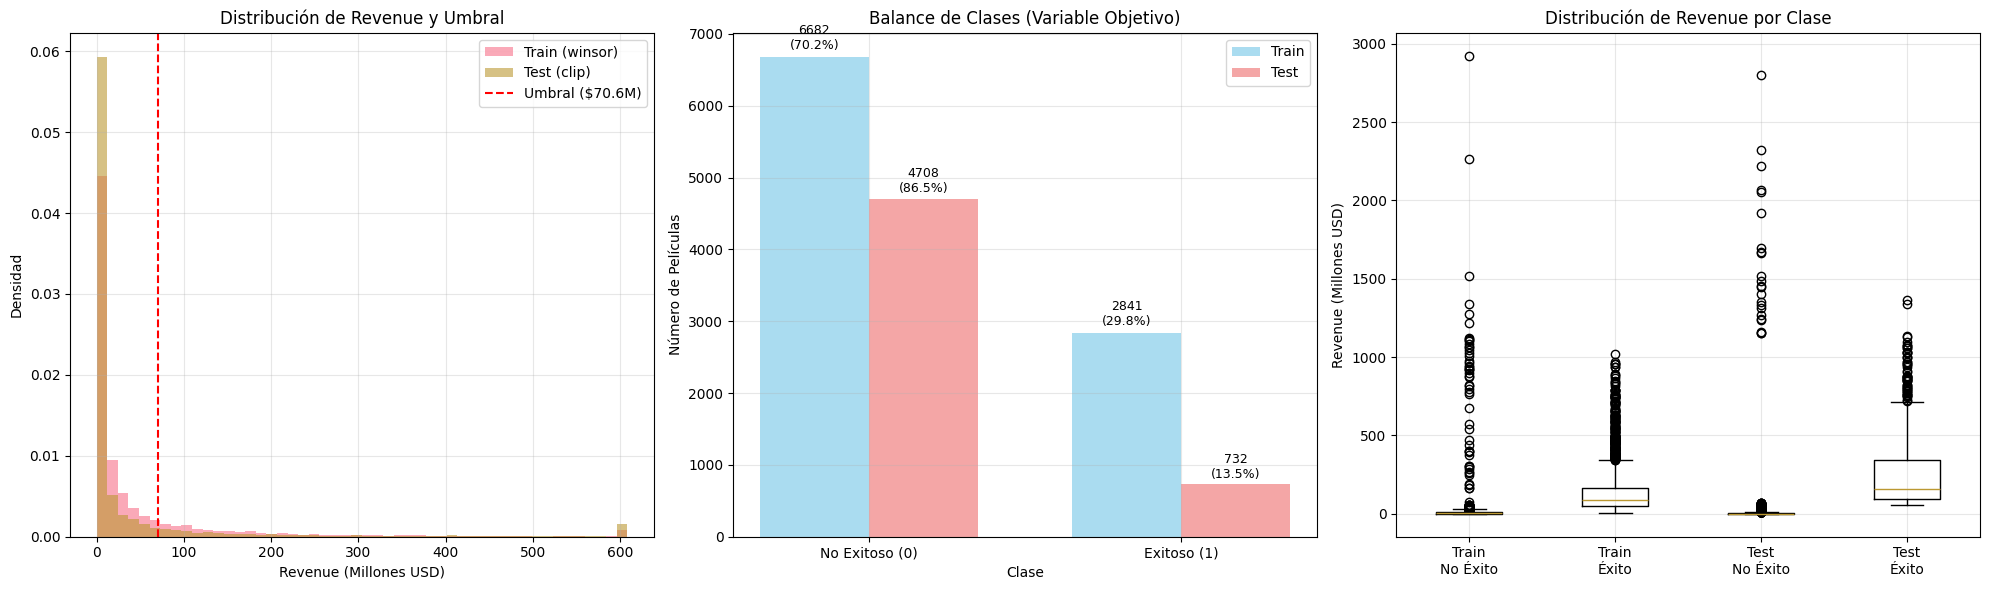


✅ FASE 1 COMPLETADA:
   • Películas train: 9,523 (29.8% exitosas)
   • Películas test: 5,440 (13.5% exitosas)
   • Split tipo: temporal
   • Valores ajustados por inflación (base 2023)

🔧 FASE 2: PREPROCESAMIENTO Y FEATURE ENGINEERING (CON INFLACIÓN)
--------------------------------------------------

CREACIÓN DE PIPELINE DE PREPROCESAMIENTO
Features numéricas: ['budget_for_model', 'runtime', 'release_year', 'release_month']
Features embedding: ['embedding']
Pipeline creado con 203 componentes SVD para embeddings

APLICACIÓN DEL PREPROCESAMIENTO
Aplicando preprocesamiento...
Preprocesamiento completado:
   X_train shape: (9523, 207)
   X_test shape: (5440, 207)
   Tipo de datos: float32
✅ FASE 2 COMPLETADA:
   • Features finales: 207 dimensiones
   • Embeddings reducidos: 3072 → 203 (SVD)
   • Preprocesamiento: Normalización + Imputación
   • Budget y Revenue ajustados por inflación incluidos

🤖 FASE 3: ENTRENAMIENTO Y EVALUACIÓN DE MODELOS
--------------------------------------------

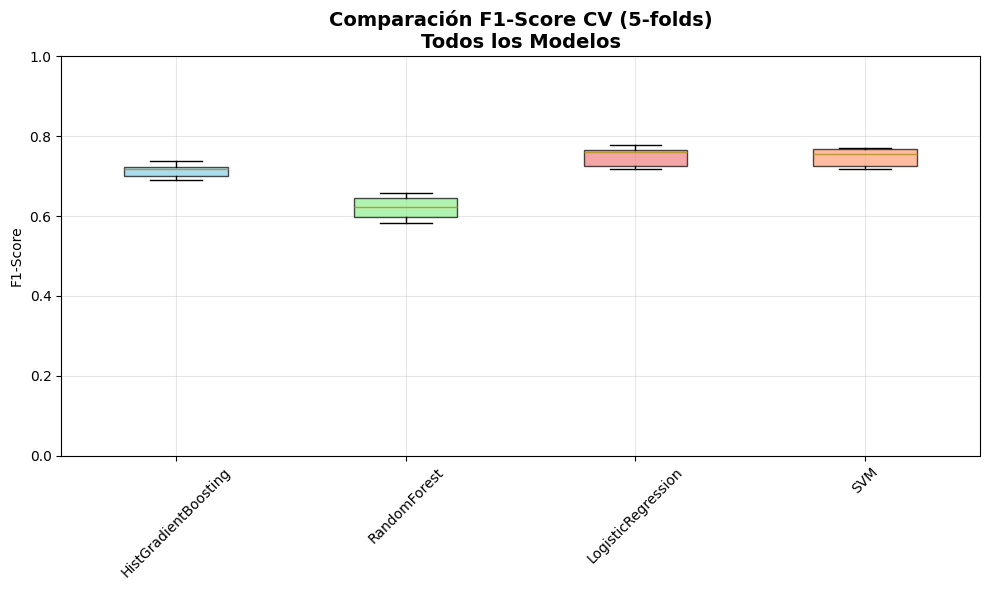


EVALUACIÓN EN CONJUNTO DE TEST

Evaluando HistGradientBoosting...
   Accuracy: 0.928
   F1-Score: 0.706
   F1-Macro: 0.833
   Balanced Accuracy: 0.809
   ROC-AUC: 0.949
   F1-CV: 0.713 (±0.017)

Evaluando RandomForest...
   Accuracy: 0.920
   F1-Score: 0.635
   F1-Macro: 0.795
   Balanced Accuracy: 0.750
   ROC-AUC: 0.939
   F1-CV: 0.621 (±0.028)

Evaluando LogisticRegression...
   Accuracy: 0.930
   F1-Score: 0.700
   F1-Macro: 0.830
   Balanced Accuracy: 0.793
   ROC-AUC: 0.941
   F1-CV: 0.750 (±0.024)

Evaluando SVM...
   Accuracy: 0.933
   F1-Score: 0.725
   F1-Macro: 0.843
   Balanced Accuracy: 0.816
   ROC-AUC: 0.941
   F1-CV: 0.747 (±0.022)

RESUMEN DE MEJORES PARÁMETROS
HistGradientBoosting: {'l2_regularization': 0.2, 'learning_rate': 0.05, 'max_depth': 8, 'max_iter': 200}
RandomForest: {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 200}
LogisticRegression: {'C': 2.0, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblin

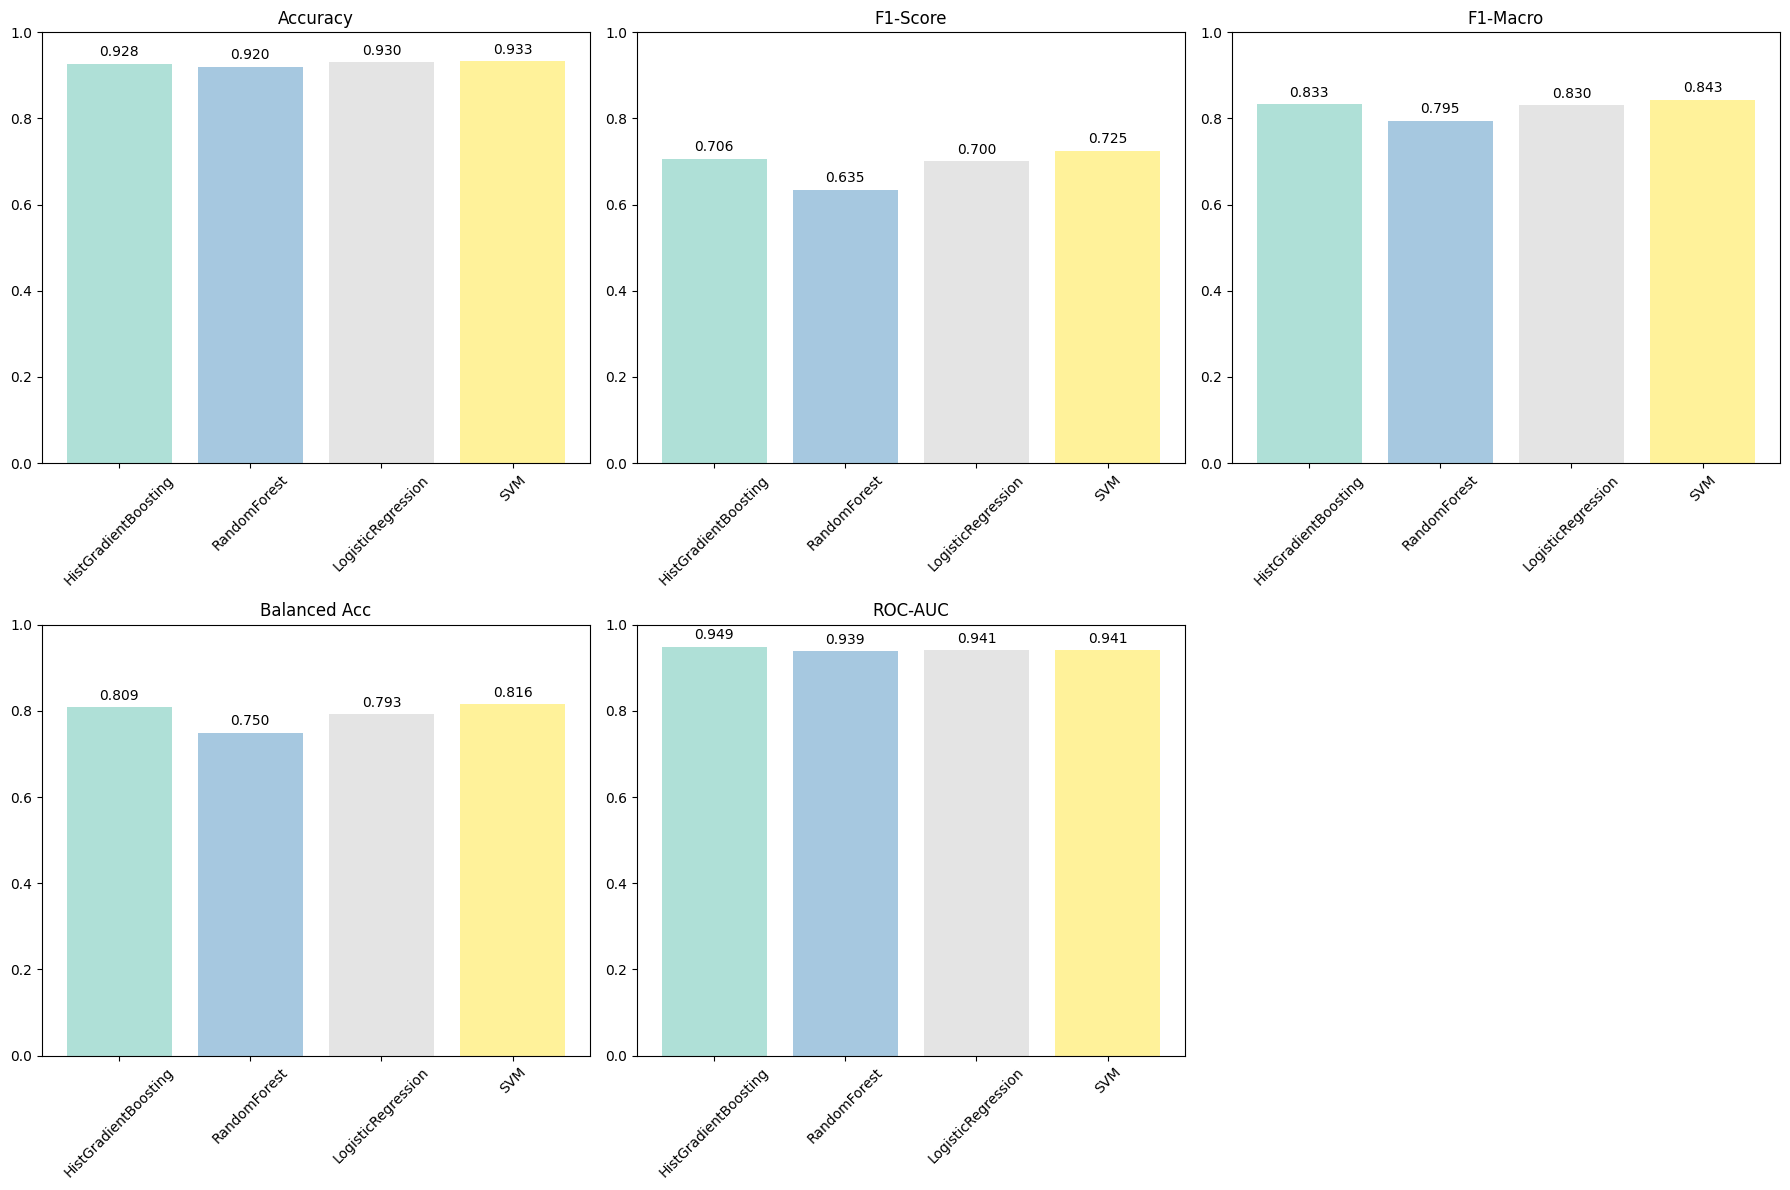

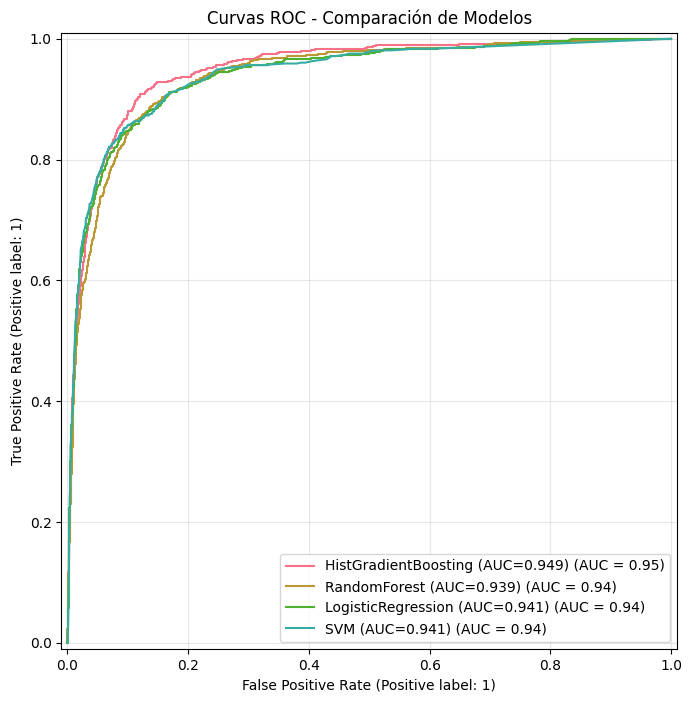


Mejor modelo por ROC-AUC: HistGradientBoosting


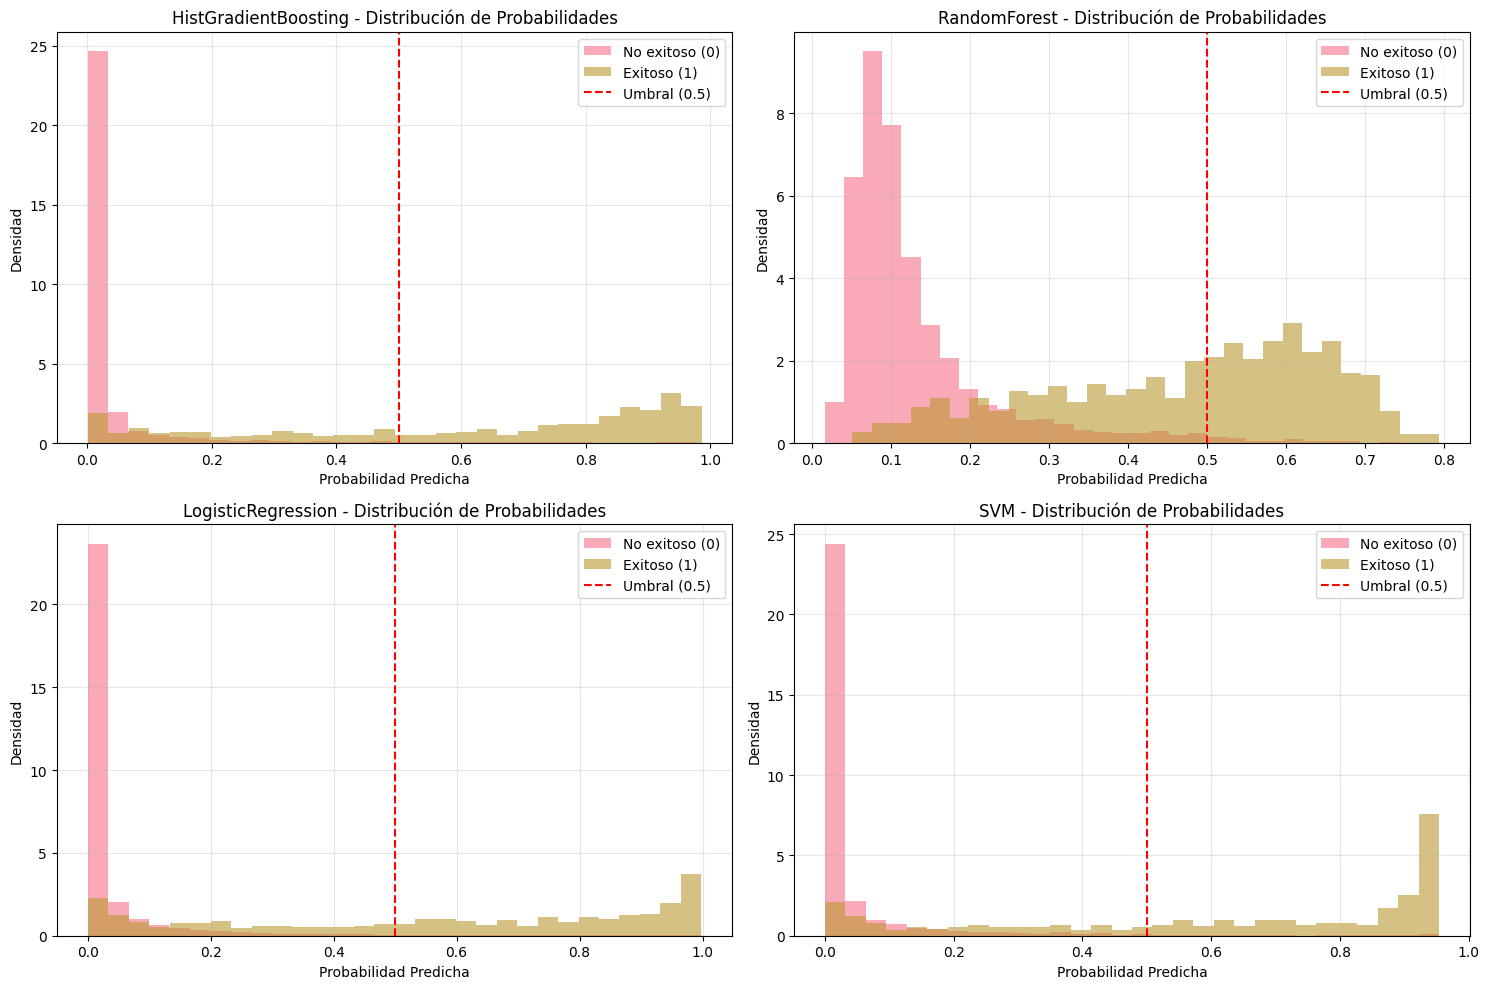

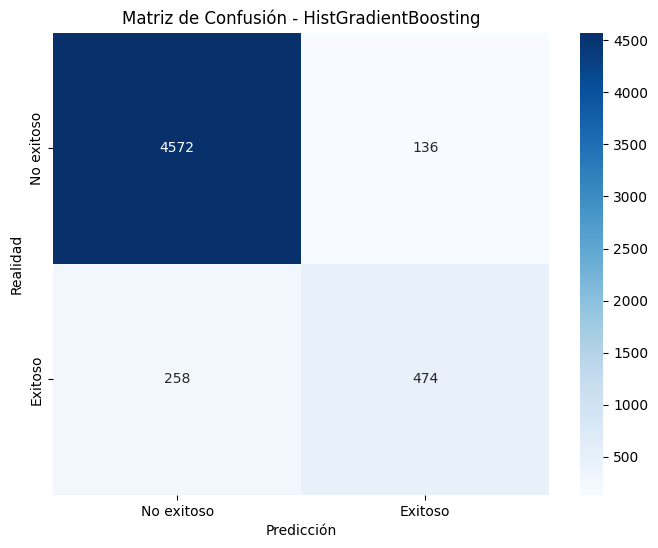

✅ FASE 3 COMPLETADA:
   • Modelos entrenados: 4
   • Mejor modelo: HistGradientBoosting
   • ROC-AUC: 0.949
   • F1-Score: 0.706

📊 FASE 4: CALIBRACIÓN Y GESTIÓN DE INCERTIDUMBRE
--------------------------------------------------

ANÁLISIS Y CALIBRACIÓN DE PROBABILIDADES


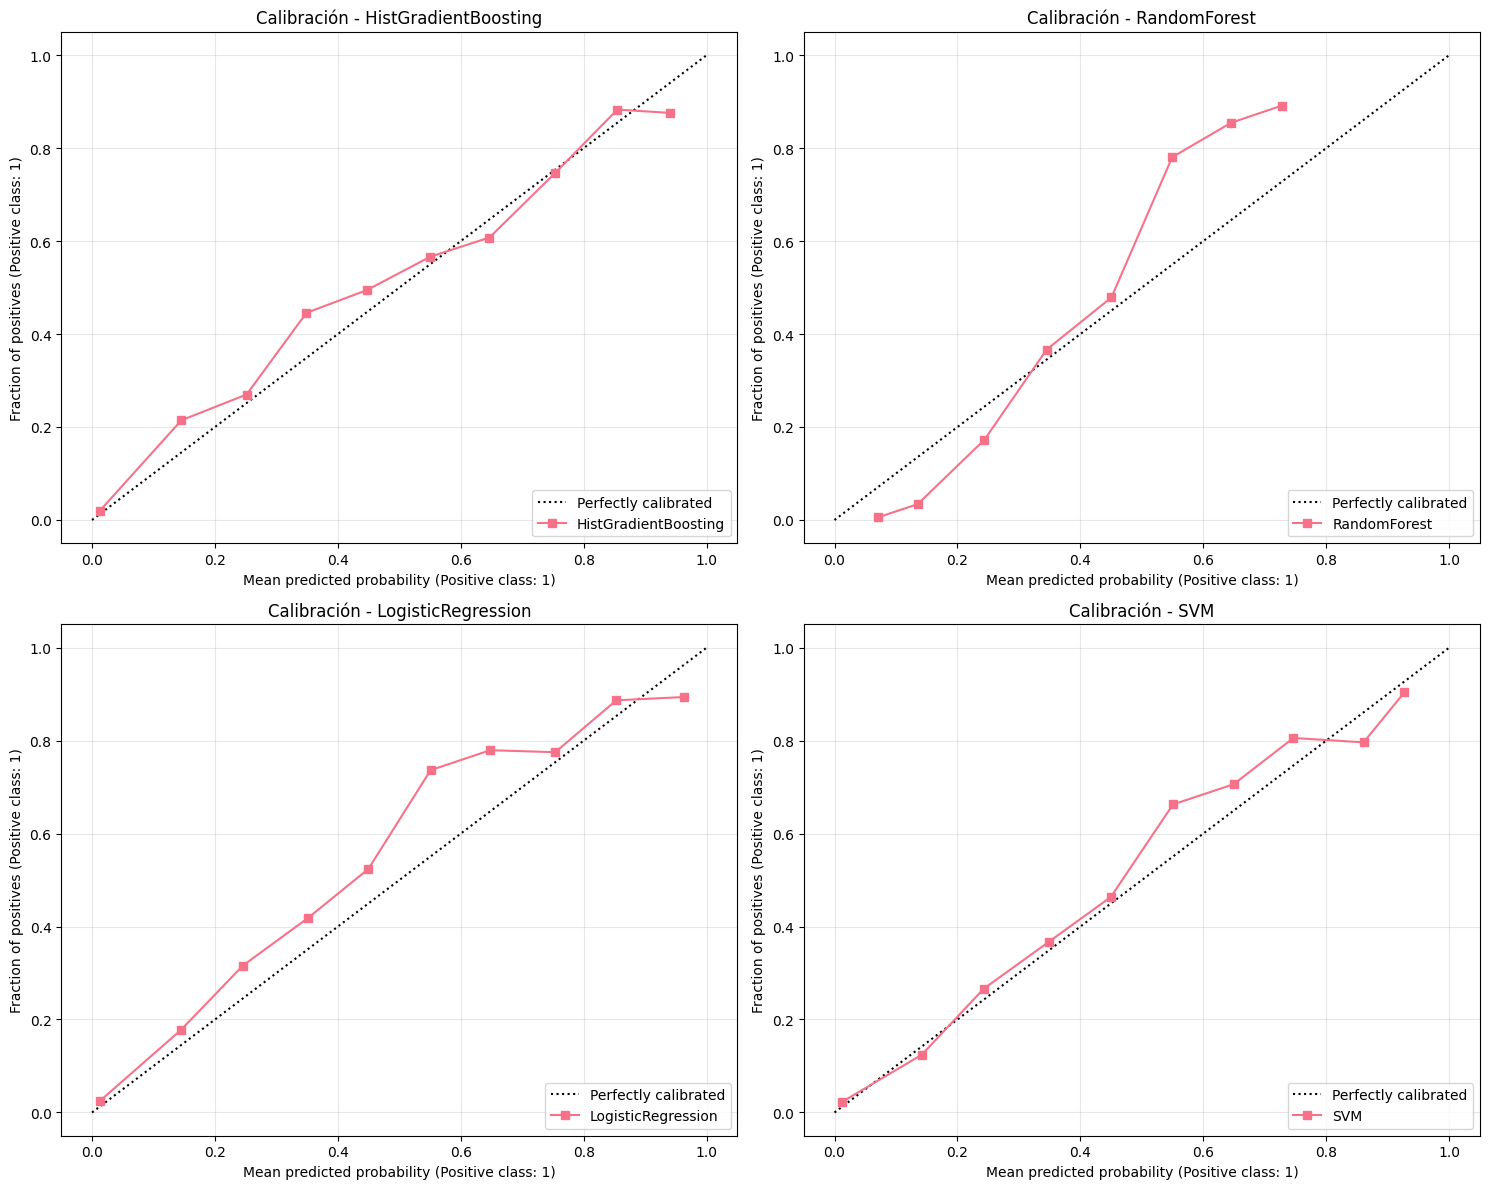


Calibrando el mejor modelo (HistGradientBoosting)...
División para calibración:
   Calibración: 2,720 muestras
   Evaluación: 2,720 muestras

MÉTRICAS DE COMPARACIÓN: ORIGINAL vs CALIBRADO
MÉTRICAS DE CLASIFICACIÓN:
   Accuracy       - Original: 0.9265 | Calibrado: 0.9246 | Δ: -0.0018
   F1-Score       - Original: 0.7050 | Calibrado: 0.7092 | Δ: +0.0042
   Balanced Acc   - Original: 0.8110 | Calibrado: 0.8226 | Δ: +0.0116
   ROC-AUC        - Original: 0.9464 | Calibrado: 0.9452 | Δ: -0.0012

MÉTRICAS DE CALIBRACIÓN (menor es mejor):
   Brier Score    - Original: 0.0549 | Calibrado: 0.0550 | Δ: +0.0001
   Reliability    - Original: 0.0437 | Calibrado: 0.0505 | Δ: +0.0068
   Log Loss       - Original: 0.1896 | Calibrado: 0.1881 | Δ: -0.0015

EVALUACIÓN DE LA CALIBRACIÓN
Mejoras en métricas de clasificación: 2/4
Mejoras en métricas de calibración: 1/3

RECOMENDACIÓN:
❌ MANTENER MODELO ORIGINAL
Razón: La mejora en calibración no es suficientemente significativa
Modelo seleccionado: HistGr

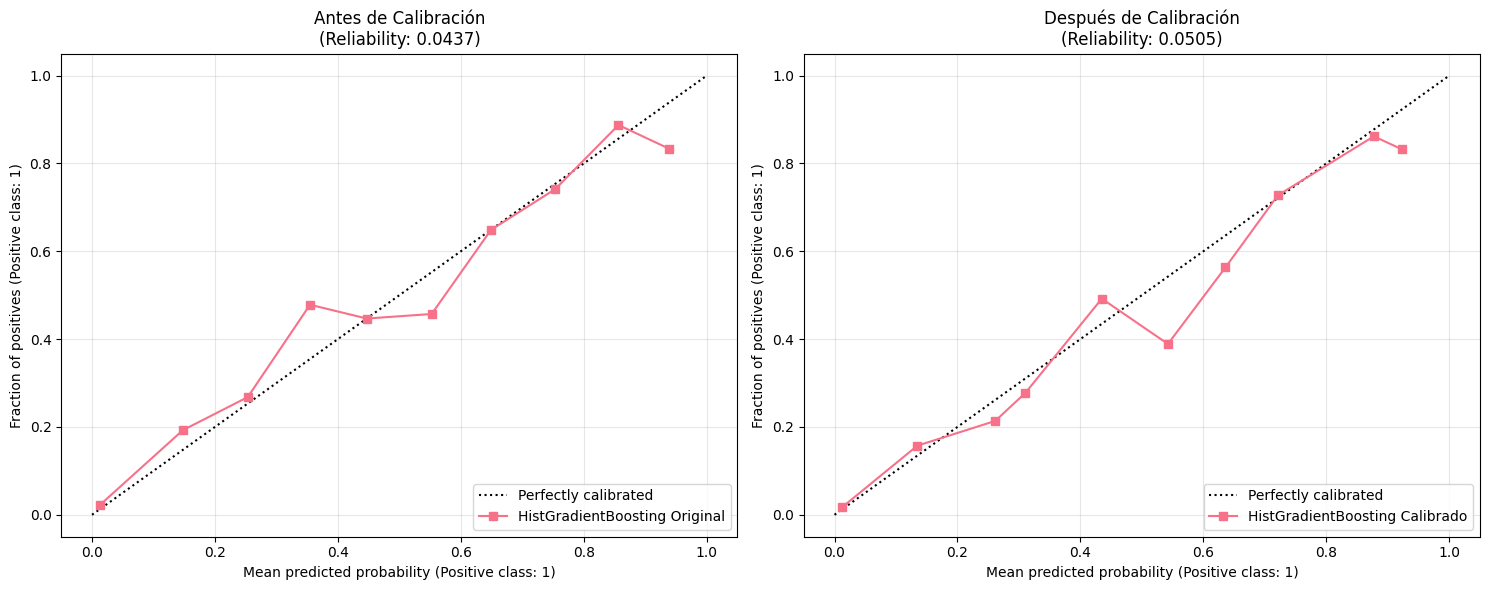


TABLA RESUMEN DE MÉTRICAS:
----------------------------------------------------------------------
              Original  Calibrado  Diferencia  Mejora (%)
Accuracy        0.9265     0.9246     -0.0018     -0.1984
F1-Score        0.7050     0.7092      0.0042      0.5965
Balanced Acc    0.8110     0.8226      0.0116      1.4339
ROC-AUC         0.9464     0.9452     -0.0012     -0.1242
Brier Score     0.0549     0.0550      0.0001      0.2321
Reliability     0.0437     0.0505      0.0068     15.5567

IMPLEMENTACIÓN DE SISTEMA DE CLASE AMBIGUA
Buscando umbral óptimo de confianza...
Umbral óptimo encontrado: 0.300
   Accuracy en casos seguros: 0.961
   Cobertura: 89.7%

Distribución de predicciones:
   No exitoso (0): 2,259 (83.1%)
   Exitoso (1): 182 (6.7%)
   Ambiguo (2): 279 (10.3%)

Rendimiento en casos no ambiguos:
   Accuracy: 0.961
   F1-Score: 0.767
   Cobertura: 2441/2720 (89.7%)


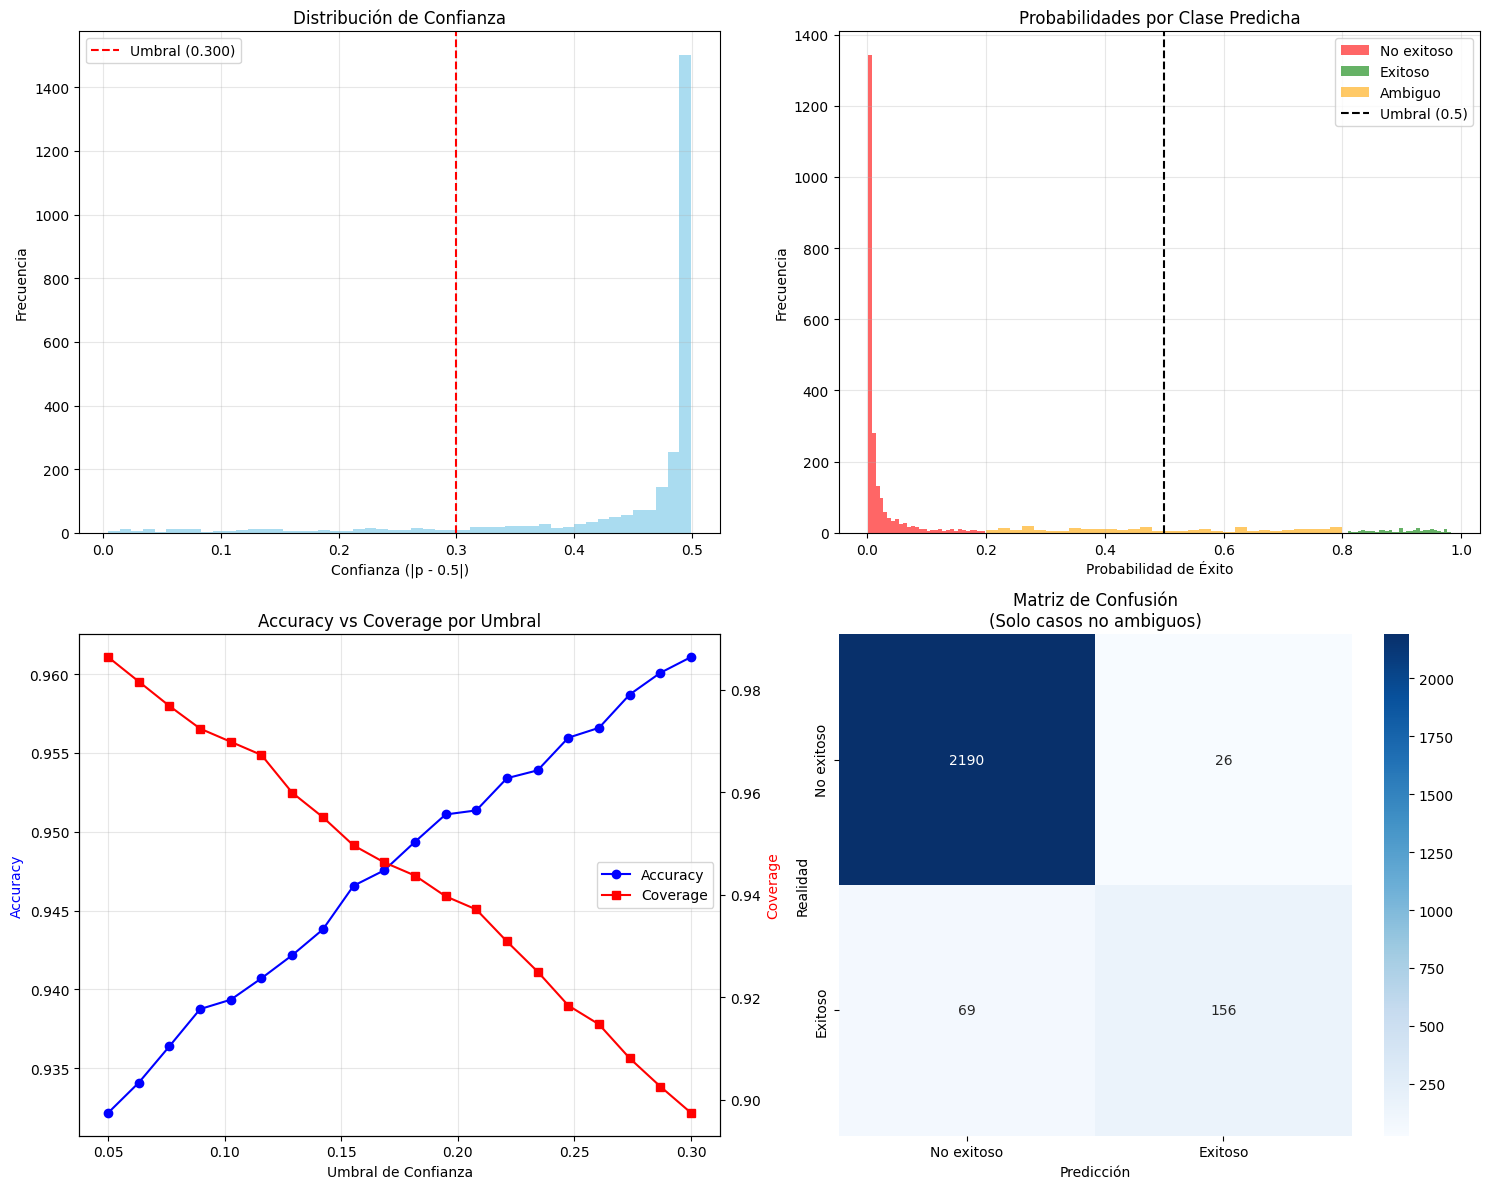

✅ FASE 4 COMPLETADA:
   • Modelo calibrado: Regresión isotónica
   • Sistema 3 clases: Implementado
   • Casos ambiguos: 10.3%
   • Umbral confianza: 0.300

🔍 FASE 5: ANÁLISIS DE FEATURES E INTERPRETACIÓN
--------------------------------------------------

ANÁLISIS DE IMPORTANCIA DE FEATURES
El modelo HistGradientBoosting no proporciona importancia de features
✅ FASE 5 COMPLETADA:
   • Análisis de importancia: Realizado
   • Interpretabilidad: Embeddings vs features tradicionales
   • Impacto de corrección por inflación: Evaluado

💾 FASE 6: GUARDADO DE RESULTADOS Y ARTEFACTOS
--------------------------------------------------

ANÁLISIS FINAL Y GUARDADO DE RESULTADOS (CON ANÁLISIS DE INFLACIÓN)

RESUMEN DE RENDIMIENTO:
----------------------------------------
Mejor modelo: HistGradientBoosting
   • Accuracy: 0.928
   • F1-Score: 0.706
   • F1-Macro: 0.833
   • Balanced Accuracy: 0.809
   • ROC-AUC: 0.949

COMPARACIÓN CON BASELINE:
----------------------------------------
Baseline (clase

In [14]:
# ## 13. Ejecución del Pipeline

if __name__ == "__main__":
    # Ejecutar pipeline principal
    pipeline_result = main_pipeline()

    # Resultado final
    if pipeline_result['success']:
        print(f"\n🎬 Pipeline ejecutado exitosamente en {pipeline_result['pipeline_duration'] / 60:.1f} min")
        print(f"🏆 Mejor modelo: {pipeline_result['best_model']} (ROC-AUC: {pipeline_result['best_roc_auc']:.3f})")
        print(f"📈 Con corrección por inflación (base {pipeline_result['base_year']})")
    else:
        print(f"\n💥 Pipeline falló: {pipeline_result['error']}")
        print(f"⏱️  Tiempo hasta fallo: {pipeline_result['pipeline_duration'] / 60:.1f} min")